### requires python 3 and TSS conda environment (needed for parallelization)

### Motivation: 
TSS: Focused and dispersed. 
Within each TSS there are variations to where the start site occurs across different tissues. 
When calling our peaks, we choose the CHO peak if it occurs, otherwise pick the tissue with the maximum p-value.

One question that arises is when we call the TSS, how different are the read alignments when a) The TSS align b) The TSS are shifted between CHO and tissues and c) No CHO peak is seen, only tissues d) only CHO TSS

For each of these, how many TSS' are seen for each. How many tissues have a TSS when they all agree with CHO and when they are offset from CHO.

When they are offset versus aligned, what is the distribution of tags underneath (the density)


In the same vein, we want to make sure that the CHO GRO-Cap and CHO csRNA peaks are both showing similar buildup profiles, and that when plotting histograms, they don't just look good because the GRO-Cap is aligning on the GRO-cap peaks and csRNA aligning on csRNA peaks. Therefore, each should be done to the opposite calls.

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
mRNA_peak_file = doc["mRNA_peak_file"]

tss_annotation = doc['tss_annotation']


import os
from os.path import join
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
from tqdm import *
from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
import helper
import create_output
print('Number of tissues: ',len(tissues))

from collections import Counter


/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


Number of tissues:  13


In [2]:
from numpanpar import parallel_df as pardf

In [3]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

## Parameters and directories

In [4]:
sample_peaks_dir = "../Results/tss_annotation_peaks/"
merged_dir = "../Results/merged"
save_dir = "Results/histograms/compare_tissues/Figures"
in_dir = "Results/histograms/compare_tissues"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

### Load data

In [5]:
merged_df = pd.read_csv("../Results/merged/samples.merge",sep="\t", index_col=0)
merged_df.head()

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Chr,Start,End,Strand,Stat,Parent files,Total subpeaks,f04_peaks/MiscOrgans_START1_and_MiscOrgans_startinput1,f04_peaks/Liver_START2_and_Liver_startinput1,f04_peaks/Brain_GROCap1_and_Brain_GRO1,...,f04_peaks/MiscOrgans_START2_and_MiscOrgans_startinput1,f04_peaks/Spleen_START1_and_Spleen_startinput1,f04_peaks/Lung_START2_and_Lung_startinput1,f04_peaks/CHO_START1_and_CHO_startinput1,f04_peaks/FemaleReproductive_START1_and_FemaleReproductive_startinput1,f04_peaks/Kidney_START2_and_Kidney_startinput1,f04_peaks/Kidney_GROCap1_and_Kidney_GRO1,f04_peaks/CHO_GROCap1_and_CHO_GRO1,f04_peaks/BMDMwt_GROCap1_and_BMDMwt_GRO1,f04_peaks/Spleen_START2_and_Spleen_startinput1
ID,,,,,,,,,,,,,,,,,,,,,
0,NW_020822452.1,16590187,16590584,+,16.227333,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,15,NW_020822452.1-1136,NaN,NW_020822452.1-1139,...,NaN,NaN,NaN,NW_020822452.1-450,NaN,NaN,NW_020822452.1-419,NW_020822452.1-145,NaN,NaN
1,NW_020822597.1,23595304,23595489,+,5.740000,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,16,NW_020822597.1-387,NaN,NW_020822597.1-324,...,NW_020822597.1-103,NW_020822597.1-248,NW_020822597.1-10,NaN,NW_020822597.1-101,NaN,NaN,NaN,NaN,NW_020822597.1-126
2,NW_020822680.1,728607,728829,+,7.579579,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,19,NW_020822680.1-92,NaN,NW_020822680.1-114,...,NaN,NaN,NaN,NW_020822680.1-37,NW_020822680.1-56,NaN,NW_020822680.1-67,NW_020822680.1-19,NW_020822680.1-44,NW_020822680.1-72
3,NW_020822602.1,10883074,10883337,+,3.992000,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,20,NW_020822602.1-204,NaN,NaN,...,NW_020822602.1-254,NW_020822602.1-122,NaN,NW_020822602.1-226,NaN,NaN,NaN,NW_020822602.1-303,NW_020822602.1-594,NW_020822602.1-266
4,NW_020822601.1,37427816,37427999,+,129.031738,f04_peaks/MiscOrgans_START1_and_MiscOrgans_sta...,23,NW_020822601.1-18,NaN,NW_020822601.1-1445,...,NW_020822601.1-52,NW_020822601.1-123,NaN,NW_020822601.1-41,NaN,NaN,NW_020822601.1-1949,NW_020822601.1-992,NW_020822601.1-2287,NW_020822601.1-12


In [6]:
meta_df = pd.read_csv("../Results/output/TSS1.exp.meta", sep="\t", index_col=0)
meta_df["ID"] = meta_df["ID"].fillna(-1).astype(int)
bed_df = read_bed_file("../Results/output/TSS1.exp.bed")
meta_df.head()


,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental
p1@Bmp4_XM_027386529.1,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b11,NaN,348823,Bmp4,NaN,XM_027386529.1,1.0
p2@Bmp4_XM_027386529.1,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,90264,Bmp4,NaN,XM_027386529.1,1.0
p3@Bmp4_XM_027386529.1,"Spleen,MiscOrgans,FemaleReproductive,Brain,Lun...",0b00,NaN,181215,Bmp4,NaN,XM_027386529.1,1.0
p1@Bmp4_XM_027386528.1,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra...",0b11,NaN,308710,Bmp4,NaN,XM_027386528.1,1.0
p1@Cdkn3_XM_027386531.1,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH...",0b11,NaN,237253,Cdkn3,NaN,XM_027386531.1,1.0


## The bed file names

In [ ]:
cho_dis3_maxDist_bed = read_bed_file(os.path.join(in_dir,"cho_disagree3_maxDistance_tol_25.tsv" ))
cho_ag3 = read_bed_file(os.path.join(in_dir, "cho_agree3_tol_25.tsv"))
cho_dis3 = read_bed_file(os.path.join(in_dir, "cho_disagree3_tol_25.tsv"))
only_in_cho = read_bed_file(os.path.join(in_dir, "cho_only_tol_25.tsv"))

In [ ]:
cho_dis3_maxDist = read_bed_file(os.path.join(in_dir,"cho_disagree3_maxDistance_tol_0.tsv" ))
cho_ag3 = read_bed_file(os.path.join(in_dir, "cho_agree3_tol_0.tsv"))
cho_dis3 = read_bed_file(os.path.join(in_dir, "cho_disagree3_tol_0.tsv"))
only_in_cho = read_bed_file(os.path.join(in_dir, "cho_only_tol_0.tsv"))

## Tolerance of 0 distance, 4kb, res=25, pc=3

annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_maxDistance_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 4000 -hist 25 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_0
(-500, 500)
Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_dis3 [-500.0, 500.0] [-0.02581882798529372, 0.6258189963182066]
(-500, 500)
Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_0 [-500.0, 500.0] [-0.02581882798529372, 0.6258189963182066]
(-500, 500)
Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_ag3 [-500.0, 500.0] [-0.028063067408772294, 0.6669733951760546]
(-500, 500)
Results/histograms/compare_tissues/Figures/hist_CHO_tags_only_in_cho [-500.0, 500.0] [-0.028063067408772294, 0.6

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


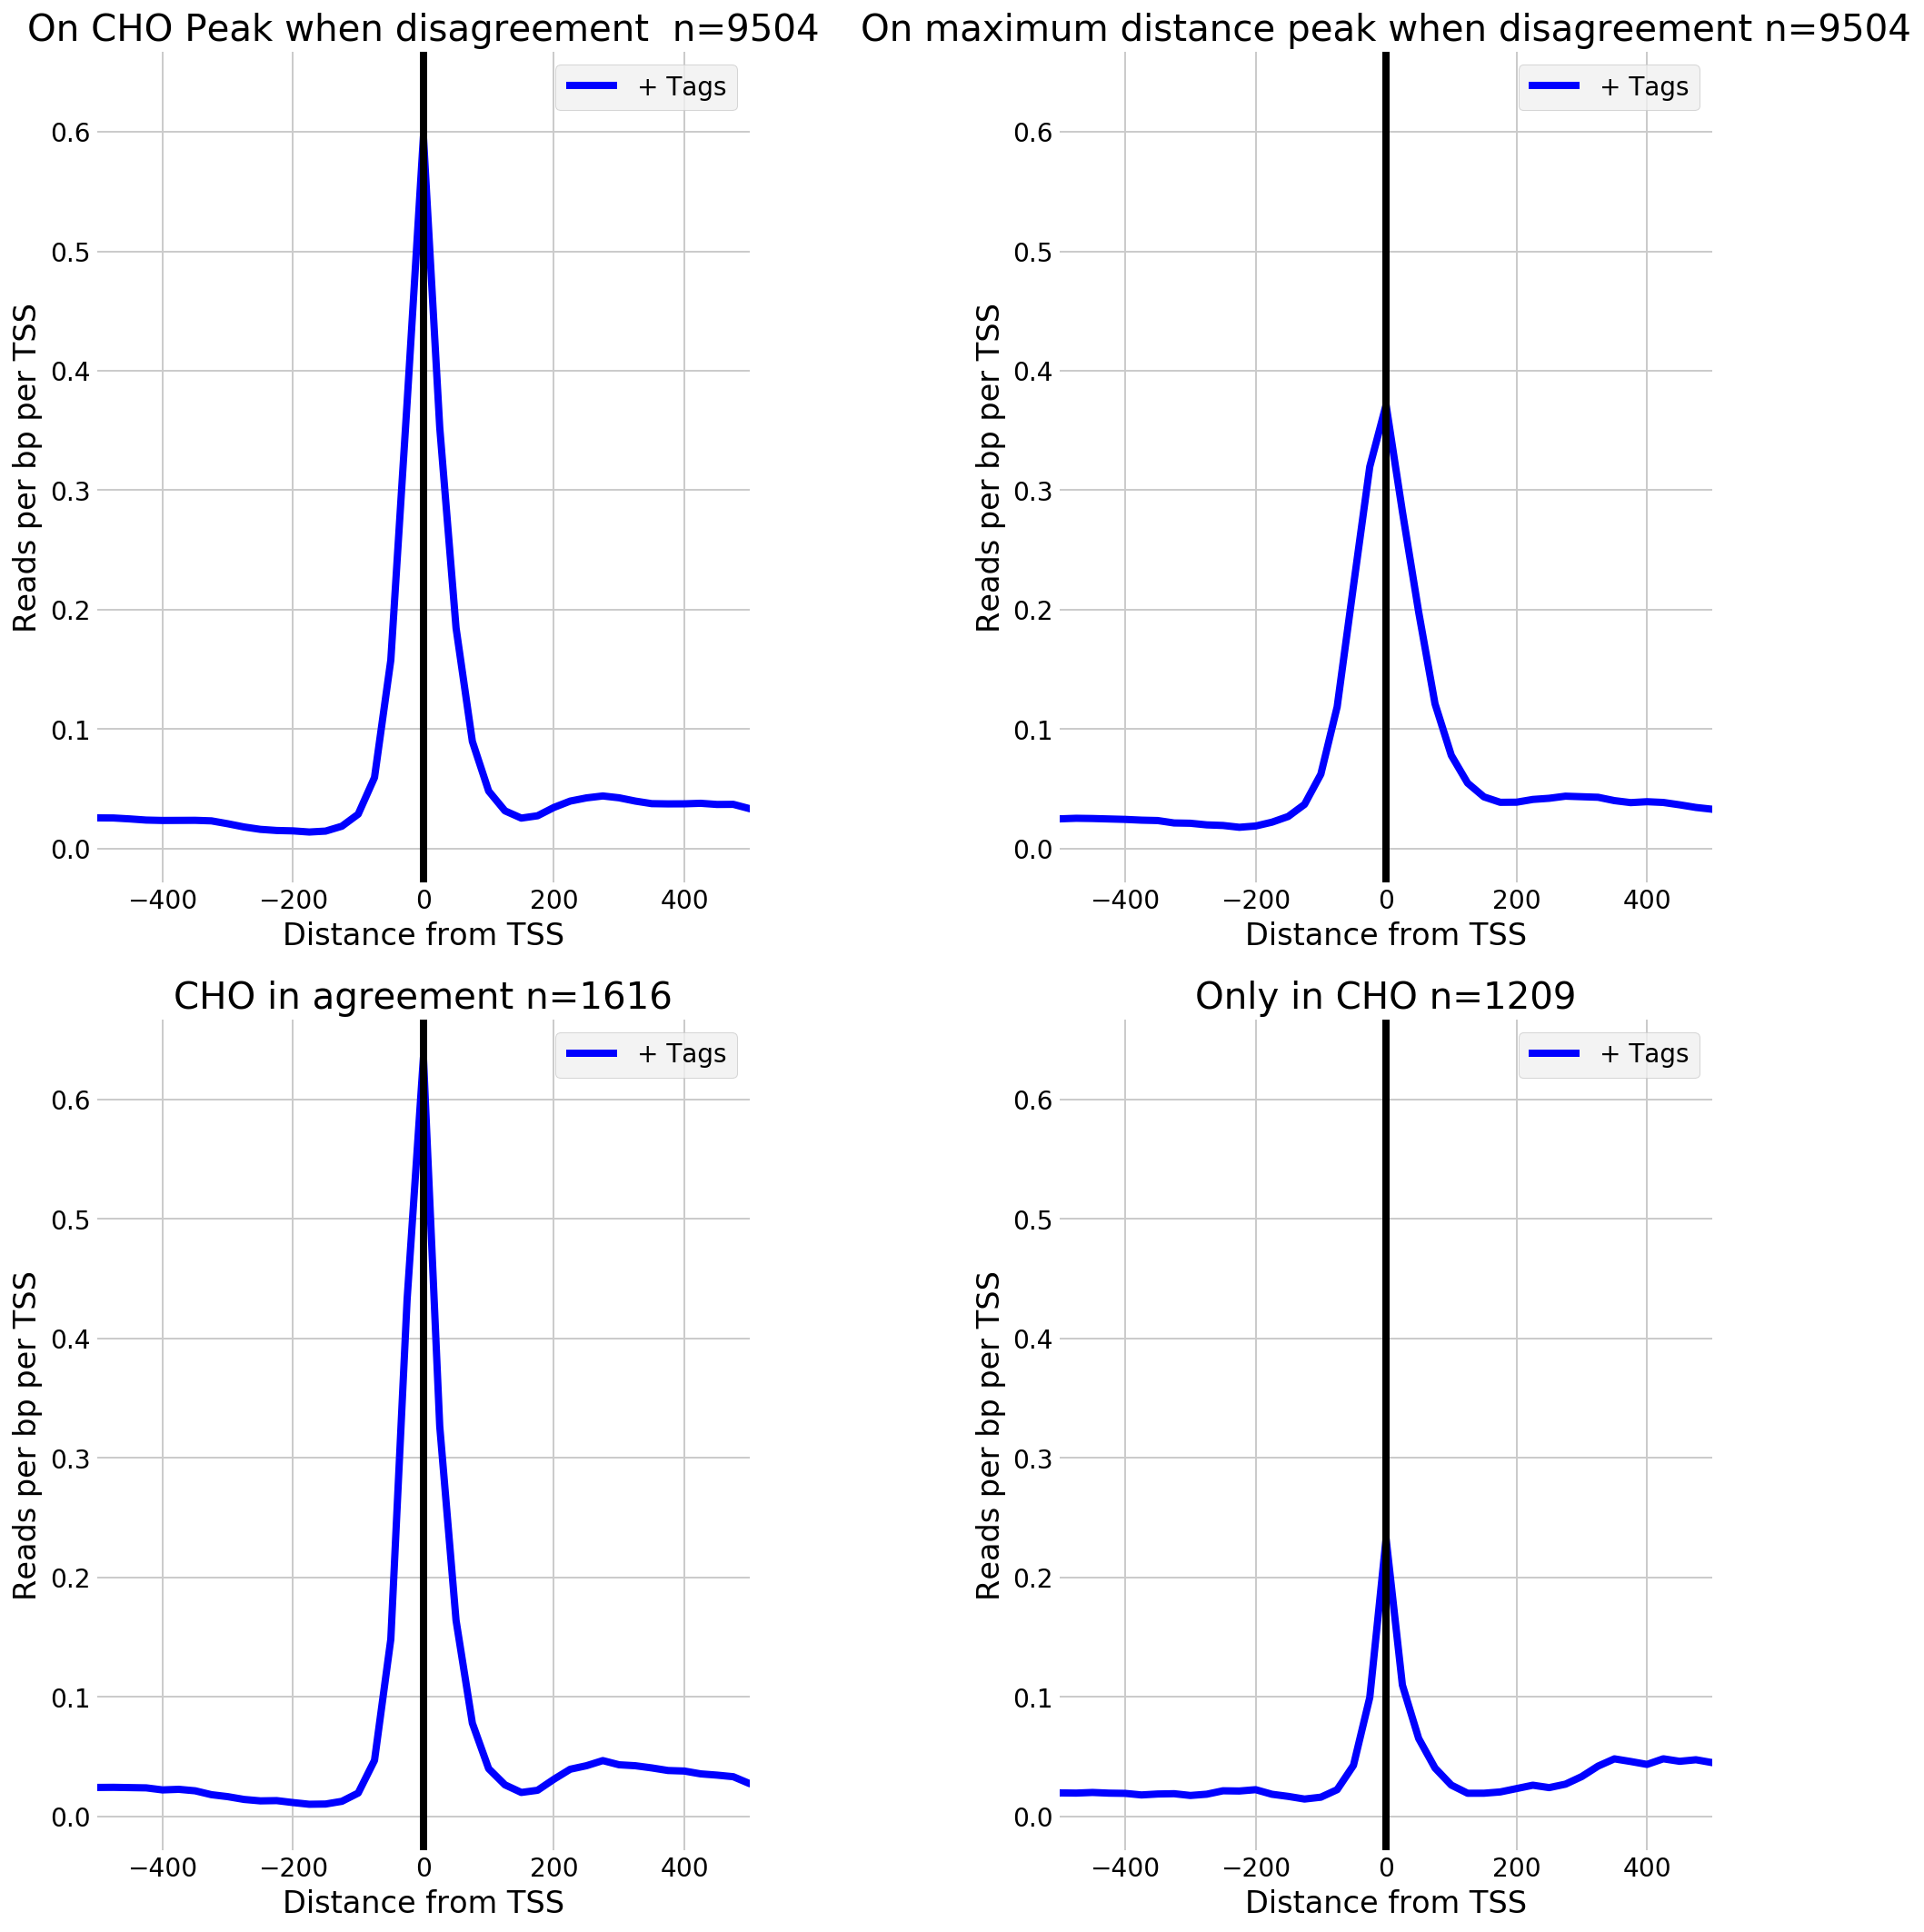

In [7]:
cho_dis3_maxDist_f = os.path.join(in_dir,"cho_disagree3_maxDistance_tol_0.tsv" )
cho_ag3_f = os.path.join(in_dir,"cho_agree3_tol_0.tsv" )
cho_dis3_f = os.path.join(in_dir,"cho_disagree3_tol_0.tsv" )
only_in_cho_f = os.path.join(in_dir, "cho_only_tol_0.tsv")


## Create RefSeq peak file for this
meta_f = "../Results/output/TSS1.exp.meta"

tissue = "CHO"
seq = "GROCap"
rep = "1"

tag_f = join(data_folder, tissue, seq, "f03_tags", "trim_" + tissue + "_" + seq + rep)


## 1.
hist_disagree3_maxDistance_tol_0 = join(save_dir,"hist_CHO_tags_disagree3_maxDistance_tol_0")

hist(tag_f,hist_disagree3_maxDistance_tol_0
     ,ref_fa,anno_gff,mode='peak',peak=cho_dis3_maxDist_f,region=4000,res=25,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)

n_disagree3_maxDistance_tol_0 = file_len(cho_dis3_maxDist_f) - 1

## 2. 
hist_cho_dis3 = join(save_dir,"hist_CHO_tags_cho_dis3")
hist(tag_f,hist_cho_dis3,ref_fa,anno_gff,mode='peak',peak=cho_dis3_f,region=4000,res=25,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_cho_dis3 = file_len(cho_dis3_f) - 1


## 3.
hist_cho_ag3 = join(save_dir,"hist_CHO_tags_cho_ag3")
hist(tag_f,hist_cho_ag3,ref_fa,anno_gff,mode='peak',peak=cho_ag3_f,region=4000,res=25,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_cho_ag3 = file_len(cho_ag3_f) - 1

hist_only_in_cho = join(save_dir,"hist_CHO_tags_only_in_cho")
hist(tag_f,hist_only_in_cho,ref_fa,anno_gff,mode='peak',peak=only_in_cho_f,region=4000,res=25,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_only_in_cho = file_len(only_in_cho_f) - 1

wrap_hist_plot([hist_cho_dis3,hist_disagree3_maxDistance_tol_0,hist_cho_ag3, hist_only_in_cho], hist_save=join(save_dir, "cho_tissues"), 
                    names=["On CHO Peak when disagreement ","On maximum distance peak when disagreement", 
                          "CHO in agreement", "Only in CHO"], include_negative=False, n=[n_cho_dis3,n_disagree3_maxDistance_tol_0,n_cho_ag3,n_only_in_cho])



## Tolerance of 0 distance, 150, res=10, pc=3

annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_maxDistance_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 10 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_0_reg150_res10
annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 10 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_dis3_reg150_res10
annotatePeaks.pl Results/histograms/compare_tissues/cho_agree3_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_00

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


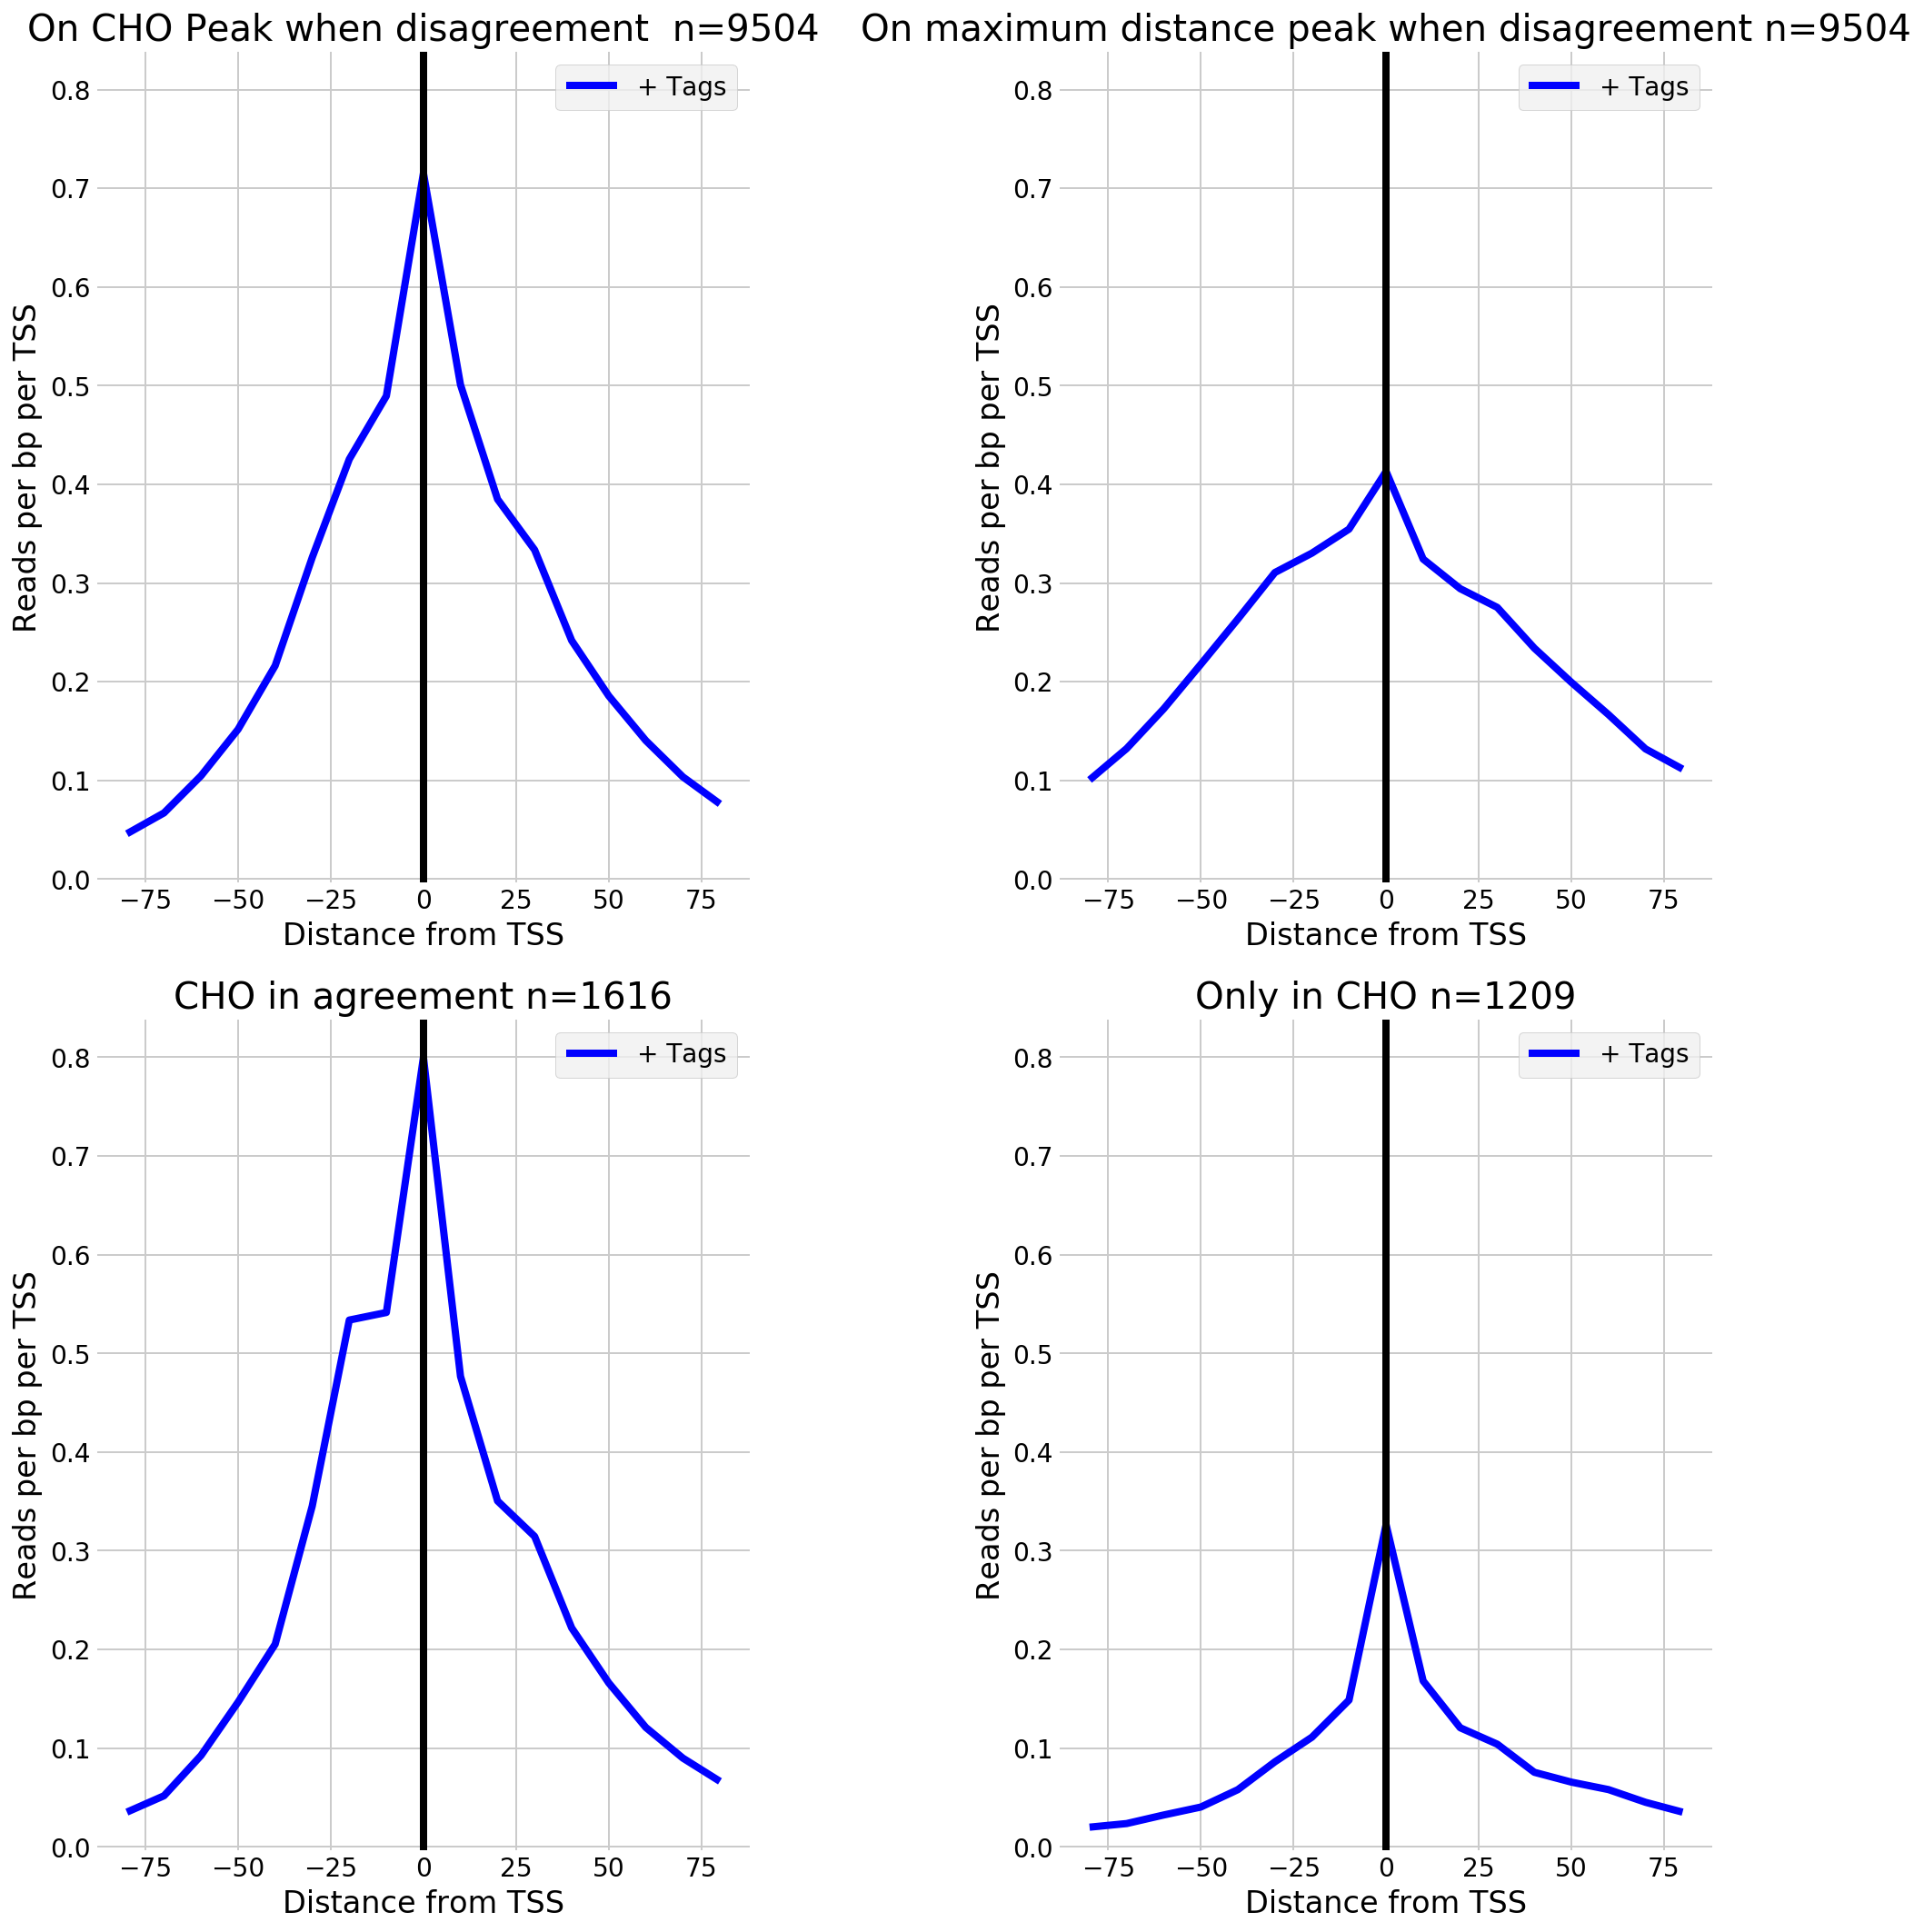

In [8]:
cho_dis3_maxDist_f = os.path.join(in_dir,"cho_disagree3_maxDistance_tol_0.tsv" )
cho_ag3_f = os.path.join(in_dir,"cho_agree3_tol_0.tsv" )
cho_dis3_f = os.path.join(in_dir,"cho_disagree3_tol_0.tsv" )
only_in_cho_f = os.path.join(in_dir, "cho_only_tol_0.tsv")


## Create RefSeq peak file for this
meta_f = "../Results/output/TSS1.exp.meta"

tissue = "CHO"
seq = "GROCap"
rep = "1"

tag_f = join(data_folder, tissue, seq, "f03_tags", "trim_" + tissue + "_" + seq + rep)


## 1.
hist_disagree3_maxDistance = join(save_dir,"hist_CHO_tags_disagree3_maxDistance_tol_0_reg150_res10")
hist(tag_f,hist_disagree3_maxDistance
     ,ref_fa,anno_gff,mode='peak',peak=cho_dis3_maxDist_f,region=150,res=10,pc=3,
    include_norm=False, include_heat=False)
n_disagree3_maxDistance = file_len(cho_dis3_maxDist_f) - 1

## 2. 
hist_cho_dis3 = join(save_dir,"hist_CHO_tags_cho_dis3_reg150_res10")
hist(tag_f,hist_cho_dis3,ref_fa,anno_gff,mode='peak',peak=cho_dis3_f,region=150,res=10,pc=3,
    include_norm=False, include_heat=False)
n_cho_dis3 = file_len(cho_dis3_f) - 1


## 3.
hist_cho_ag3 = join(save_dir,"hist_CHO_tags_cho_ag3_reg150_res10")
hist(tag_f,hist_cho_ag3,ref_fa,anno_gff,mode='peak',peak=cho_ag3_f,region=150,res=10,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_cho_ag3 = file_len(cho_ag3_f) - 1

hist_only_in_cho = join(save_dir,"hist_CHO_tags_only_in_cho_reg150_res10")
hist(tag_f,hist_only_in_cho,ref_fa,anno_gff,mode='peak',peak=only_in_cho_f,region=150,res=10,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_only_in_cho = file_len(only_in_cho_f) - 1

wrap_hist_plot([hist_cho_dis3, hist_disagree3_maxDistance, 
                hist_cho_ag3, hist_only_in_cho], hist_save=join(save_dir, "cho_tissues_tol0_reg150_res10"), 
                    names=["On CHO Peak when disagreement ","On maximum distance peak when disagreement", 
                          "CHO in agreement", "Only in CHO"], include_negative=False, n=[n_cho_dis3,n_disagree3_maxDistance,n_cho_ag3,n_only_in_cho], 
              xlims=None)


## Tolerance of 0 distance, size=500, res=1, pc=3

annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_maxDistance_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 500 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_0_reg500_res1
annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 500 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_dis3_reg500_res1
annotatePeaks.pl Results/histograms/compare_tissues/cho_agree3_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


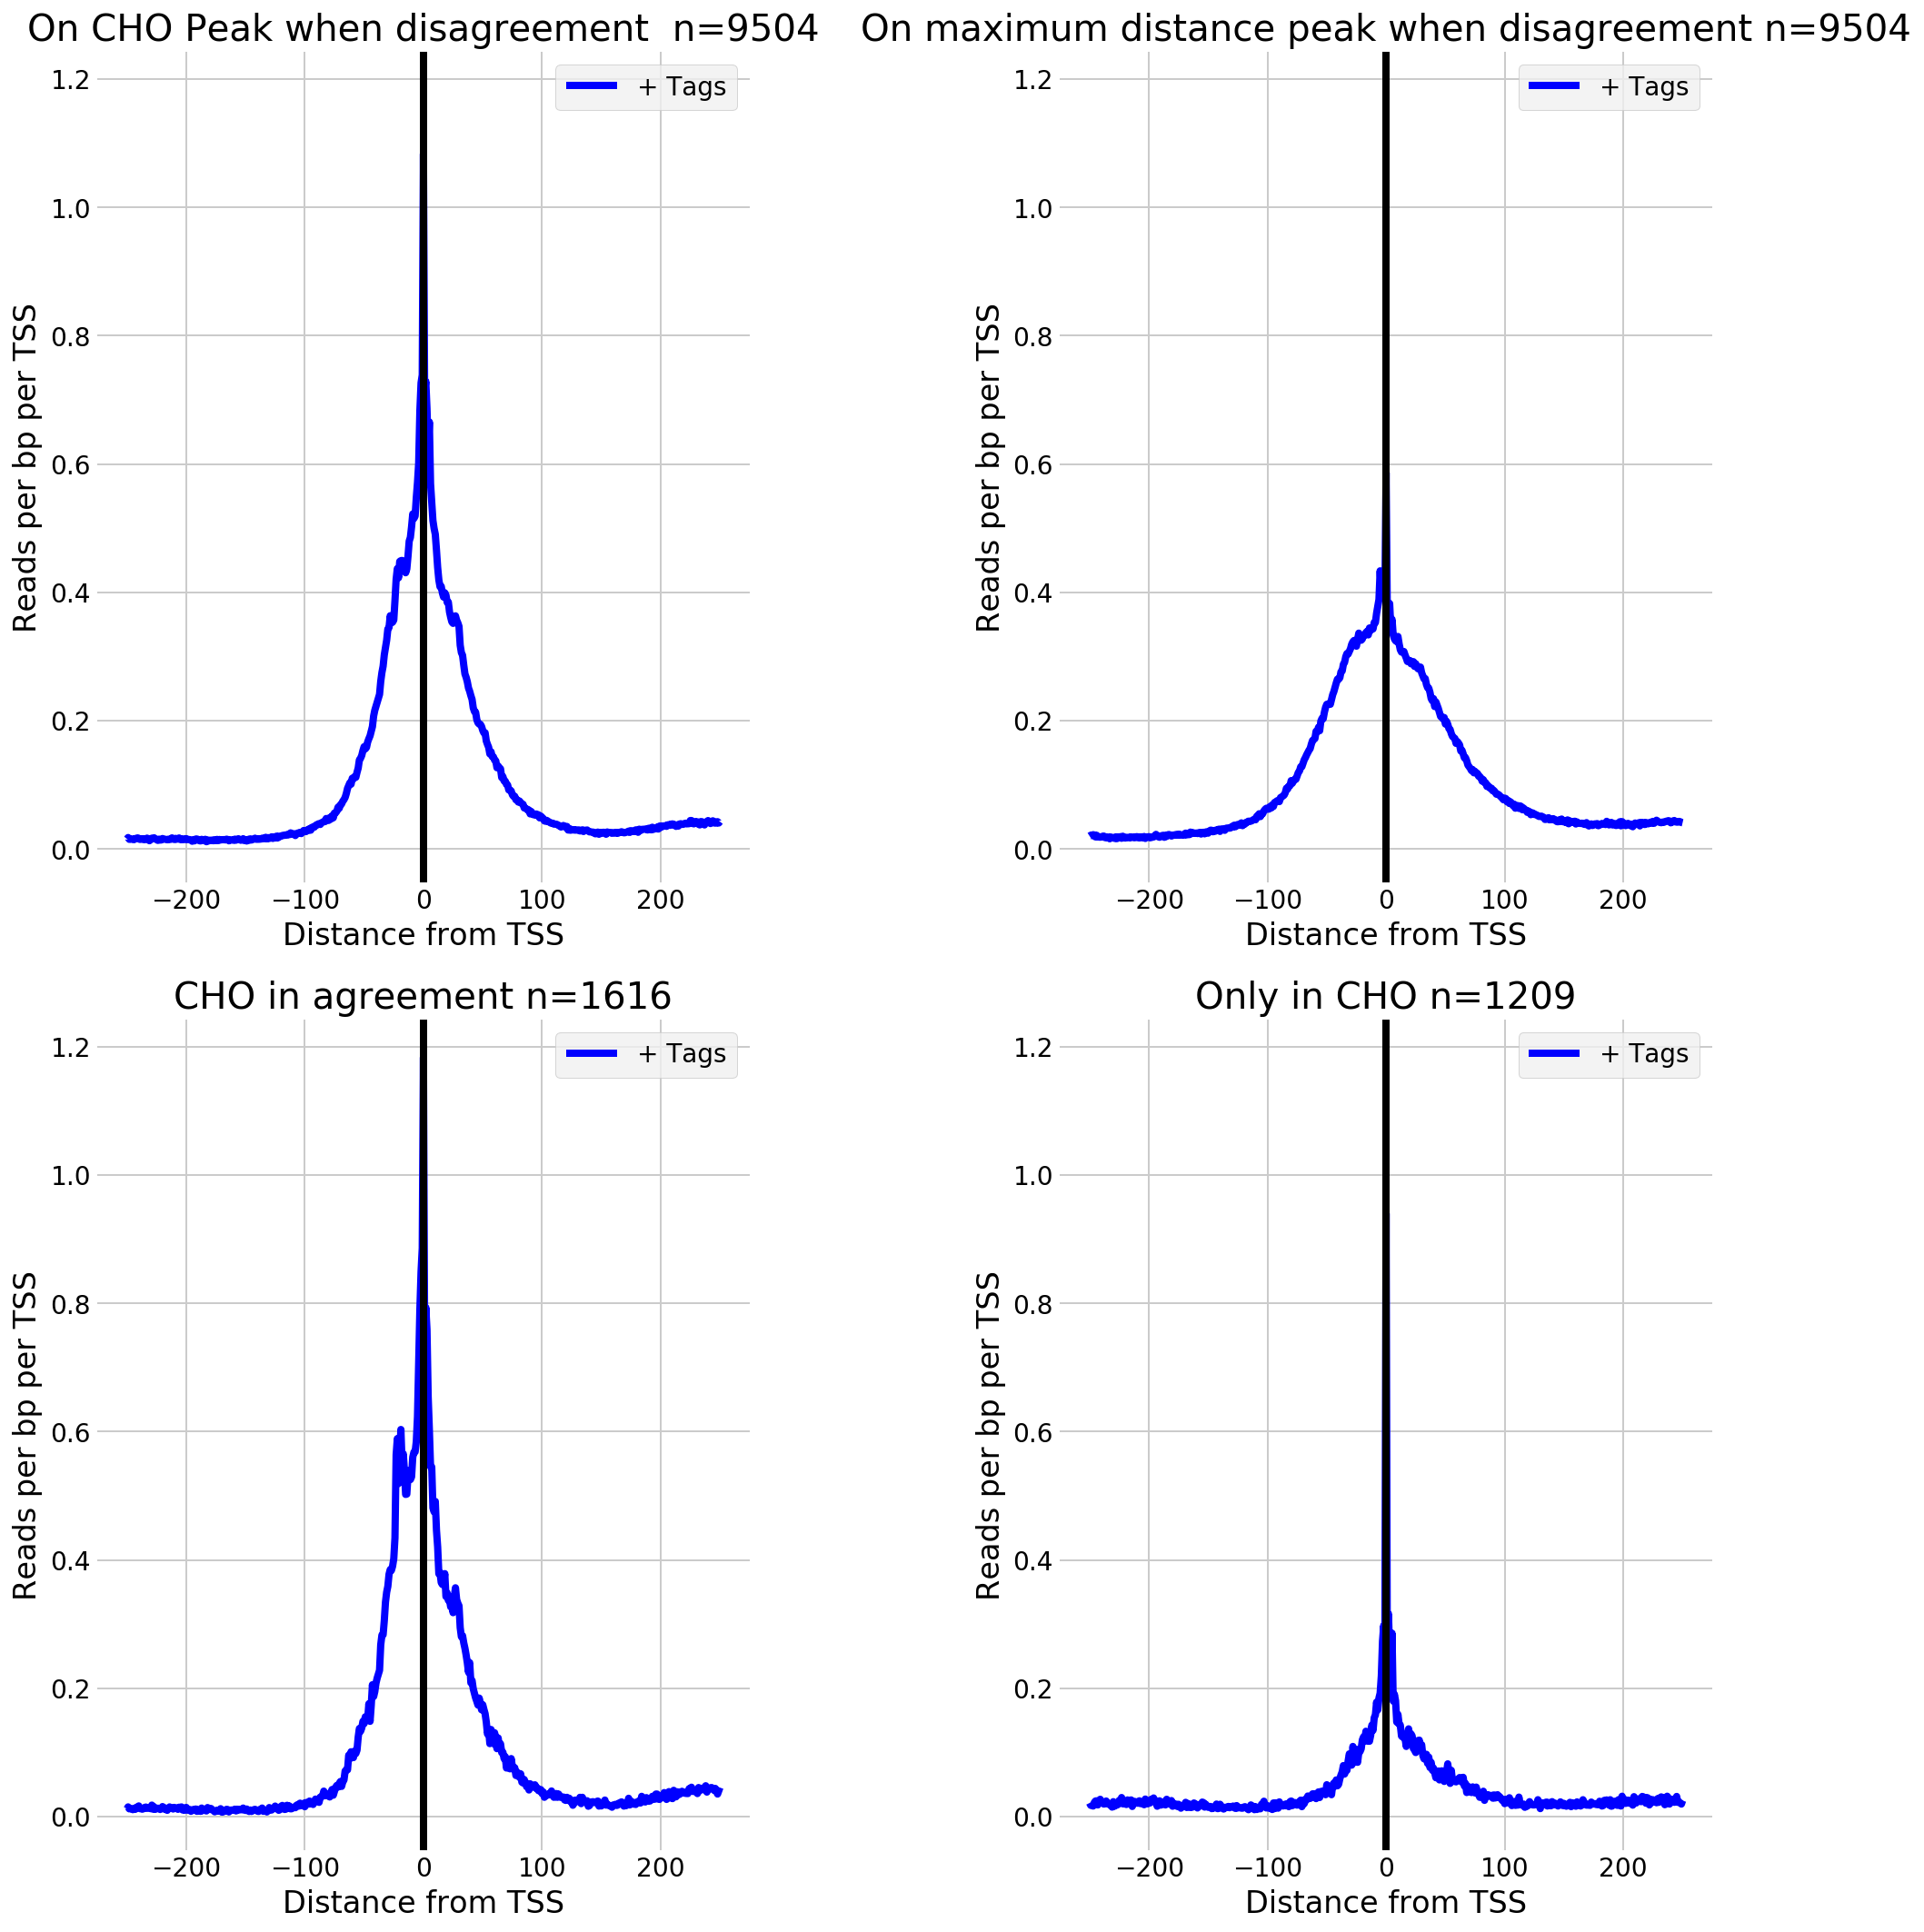

In [15]:
cho_dis3_maxDist_f = os.path.join(in_dir,"cho_disagree3_maxDistance_tol_0.tsv" )
cho_ag3_f = os.path.join(in_dir,"cho_agree3_tol_0.tsv" )
cho_dis3_f = os.path.join(in_dir,"cho_disagree3_tol_0.tsv" )
only_in_cho_f = os.path.join(in_dir, "cho_only_tol_0.tsv")


## Create RefSeq peak file for this
meta_f = "../Results/output/TSS1.exp.meta"

tissue = "CHO"
seq = "GROCap"
rep = "1"

tag_f = join(data_folder, tissue, seq, "f03_tags", "trim_" + tissue + "_" + seq + rep)


## 1.
hist_disagree3_maxDistance = join(save_dir,"hist_CHO_tags_disagree3_maxDistance_tol_0_reg500_res1")
hist(tag_f,hist_disagree3_maxDistance
     ,ref_fa,anno_gff,mode='peak',peak=cho_dis3_maxDist_f,region=500,res=1,pc=3,
    include_norm=False, include_heat=False)
n_disagree3_maxDistance = file_len(cho_dis3_maxDist_f) - 1

## 2. 
hist_cho_dis3 = join(save_dir,"hist_CHO_tags_cho_dis3_reg500_res1")
hist(tag_f,hist_cho_dis3,ref_fa,anno_gff,mode='peak',peak=cho_dis3_f,region=500,res=1,pc=3,
    include_norm=False, include_heat=False)
n_cho_dis3 = file_len(cho_dis3_f) - 1


## 3.
hist_cho_ag3 = join(save_dir,"hist_CHO_tags_cho_ag3_reg500_res1")
hist(tag_f,hist_cho_ag3,ref_fa,anno_gff,mode='peak',peak=cho_ag3_f,region=500,res=1,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_cho_ag3 = file_len(cho_ag3_f) - 1

hist_only_in_cho = join(save_dir,"hist_CHO_tags_only_in_cho_reg500_res1")
hist(tag_f,hist_only_in_cho,ref_fa,anno_gff,mode='peak',peak=only_in_cho_f,region=500,res=1,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_only_in_cho = file_len(only_in_cho_f) - 1

wrap_hist_plot([hist_cho_dis3, hist_disagree3_maxDistance, 
                hist_cho_ag3, hist_only_in_cho], hist_save=join(save_dir, "cho_tissues_tol0_reg500_res1"), 
                    names=["On CHO Peak when disagreement ","On maximum distance peak when disagreement", 
                          "CHO in agreement", "Only in CHO"], include_negative=False, n=[n_cho_dis3,n_disagree3_maxDistance,n_cho_ag3,n_only_in_cho], 
              xlims=None)


## Tolerance of 0 distance, size=150, res=1, pc=0

annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_maxDistance_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 0 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_0_reg150_res1
annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 0 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_dis3_reg150_res1
annotatePeaks.pl Results/histograms/compare_tissues/cho_agree3_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

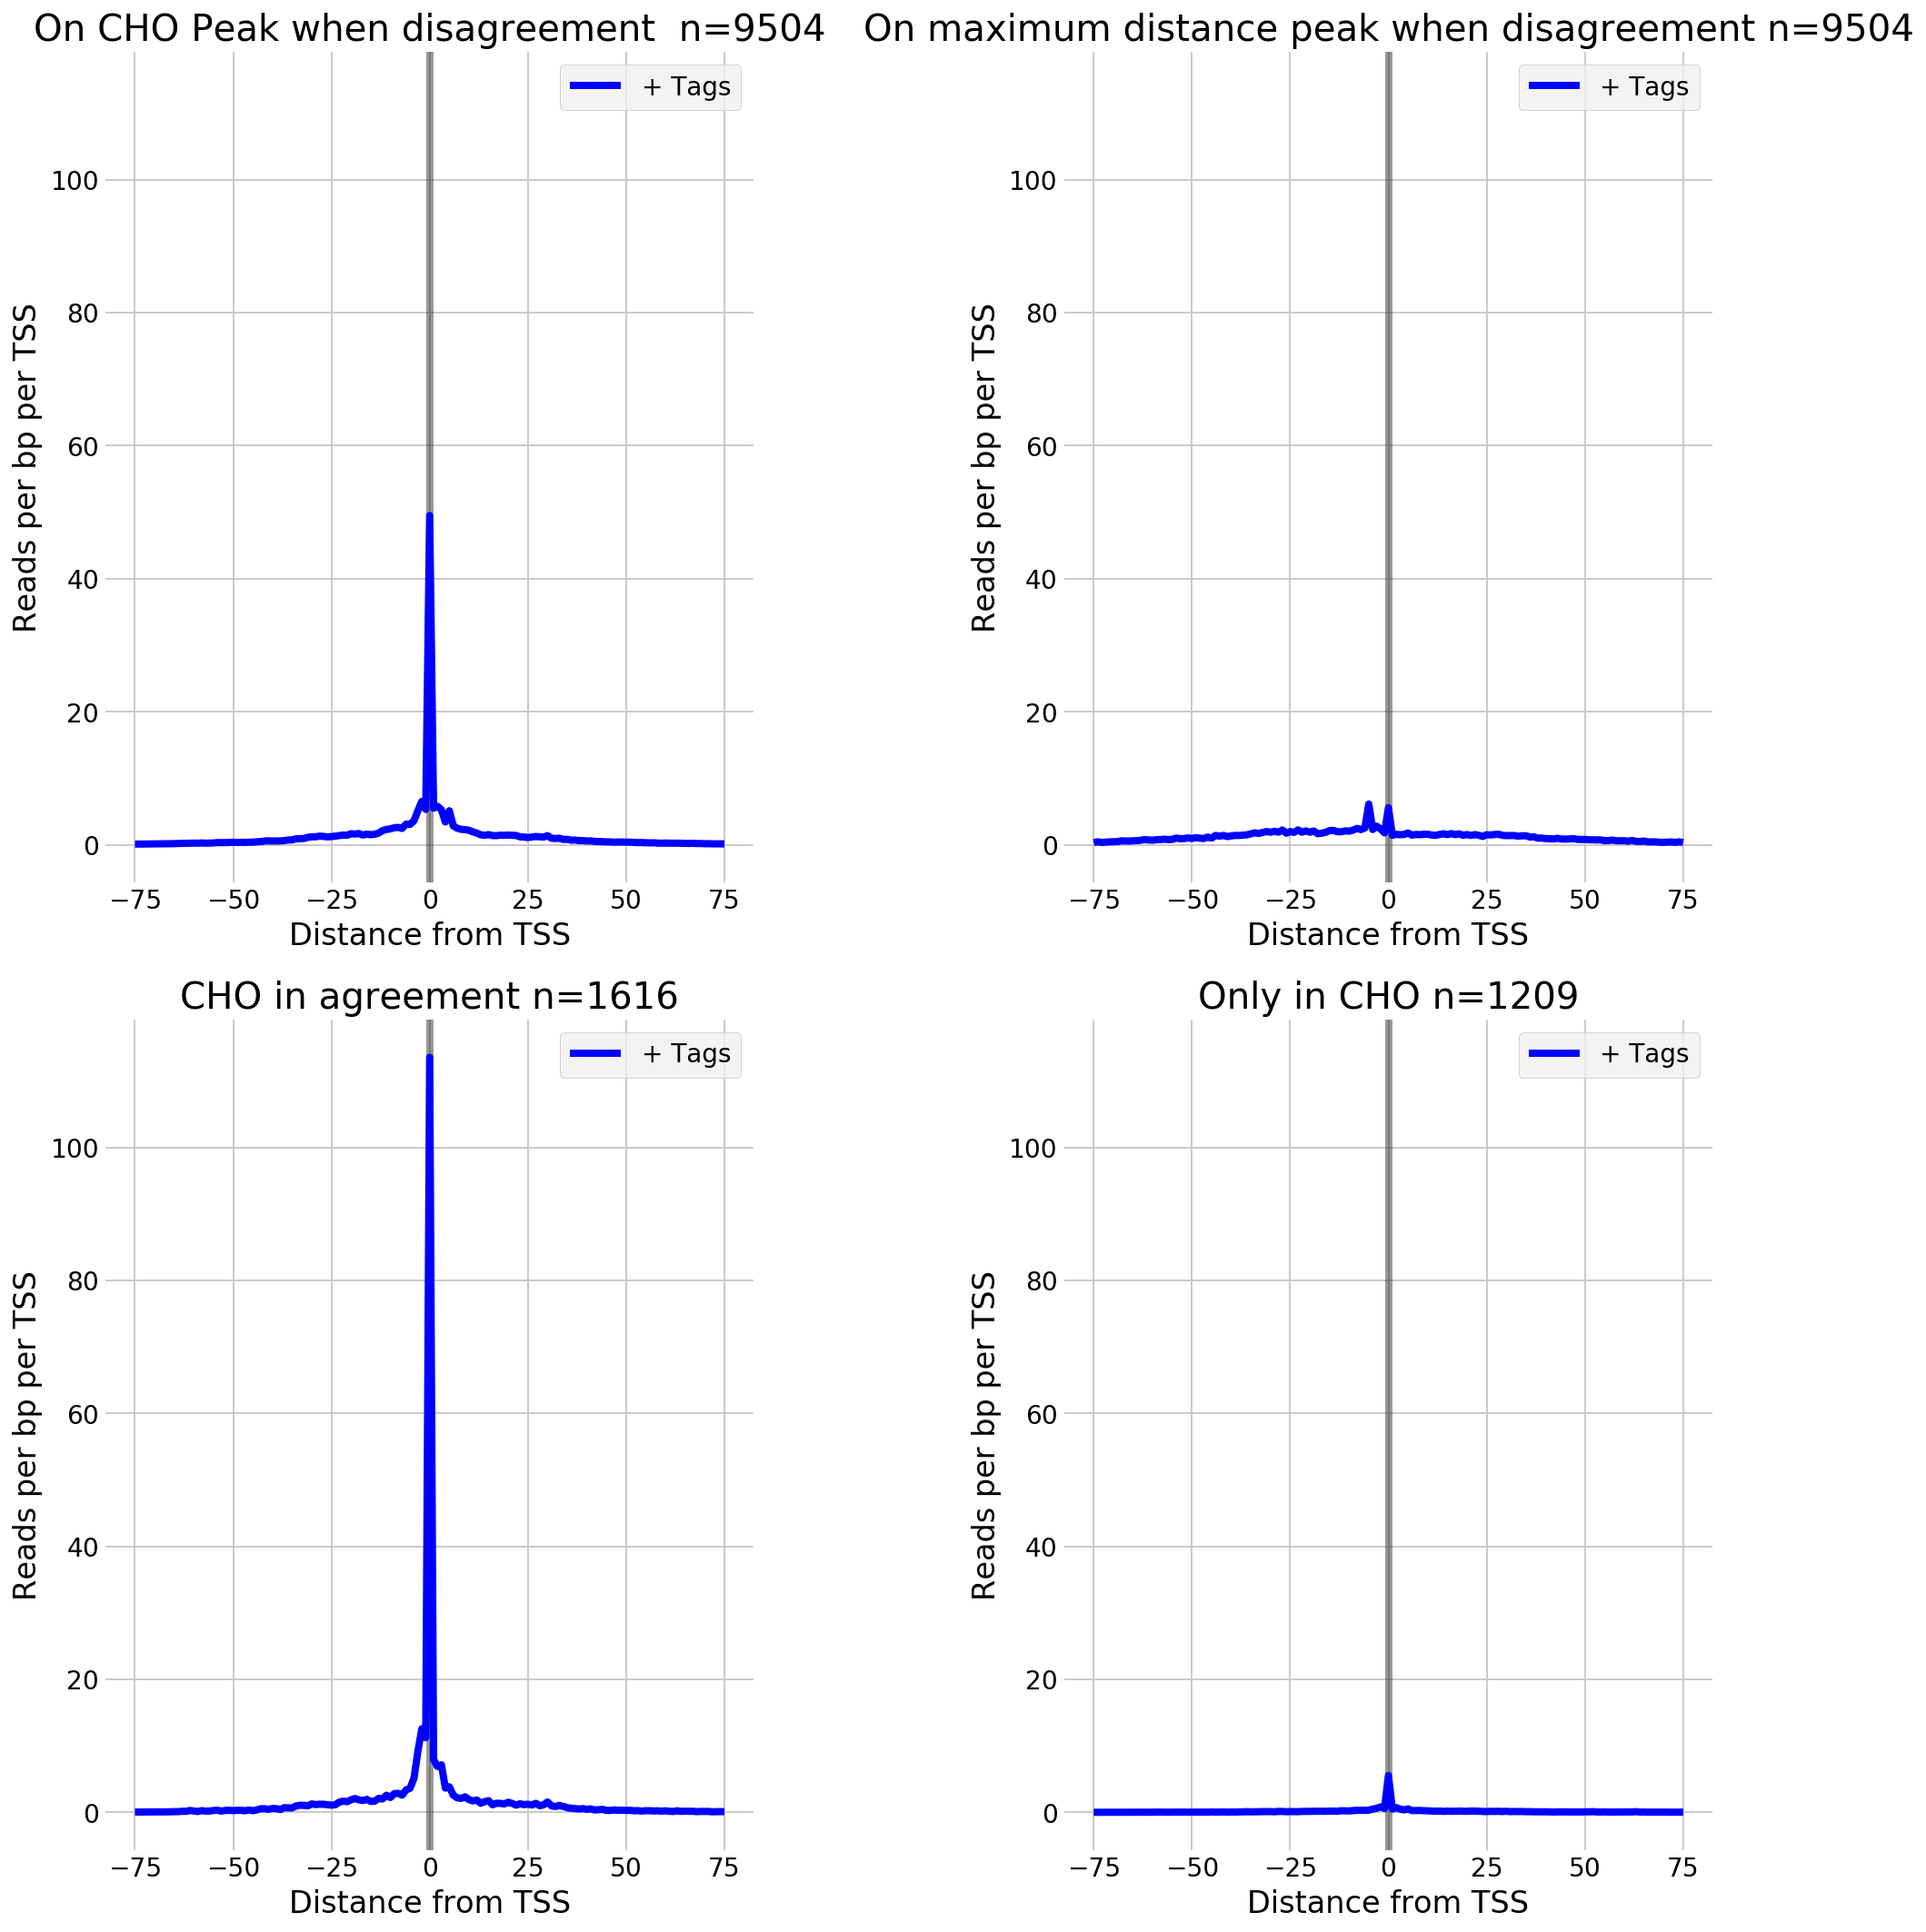

In [22]:
cho_dis3_maxDist_f = os.path.join(in_dir,"cho_disagree3_maxDistance_tol_0.tsv" )
cho_ag3_f = os.path.join(in_dir,"cho_agree3_tol_0.tsv" )
cho_dis3_f = os.path.join(in_dir,"cho_disagree3_tol_0.tsv" )
only_in_cho_f = os.path.join(in_dir, "cho_only_tol_0.tsv")


## Create RefSeq peak file for this
meta_f = "../Results/output/TSS1.exp.meta"

tissue = "CHO"
seq = "GROCap"
rep = "1"

tag_f = join(data_folder, tissue, seq, "f03_tags", "trim_" + tissue + "_" + seq + rep)


## 1.
hist_disagree3_maxDistance = join(save_dir,"hist_CHO_tags_disagree3_maxDistance_tol_0_reg150_res1")
hist(tag_f,hist_disagree3_maxDistance
     ,ref_fa,anno_gff,mode='peak',peak=cho_dis3_maxDist_f,region=150,res=1,
    include_norm=False, include_heat=False)
n_disagree3_maxDistance = file_len(cho_dis3_maxDist_f) - 1

## 2. 
hist_cho_dis3 = join(save_dir,"hist_CHO_tags_cho_dis3_reg150_res1")
hist(tag_f,hist_cho_dis3,ref_fa,anno_gff,mode='peak',peak=cho_dis3_f,region=150,res=1,
    include_norm=False, include_heat=False)
n_cho_dis3 = file_len(cho_dis3_f) - 1


## 3.
hist_cho_ag3 = join(save_dir,"hist_CHO_tags_cho_ag3_reg150_res1")
hist(tag_f,hist_cho_ag3,ref_fa,anno_gff,mode='peak',peak=cho_ag3_f,region=150,res=1,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_cho_ag3 = file_len(cho_ag3_f) - 1

hist_only_in_cho = join(save_dir,"hist_CHO_tags_only_in_cho_reg150_res1")
hist(tag_f,hist_only_in_cho,ref_fa,anno_gff,mode='peak',peak=only_in_cho_f,region=150,res=1,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_only_in_cho = file_len(only_in_cho_f) - 1

wrap_hist_plot([hist_cho_dis3, hist_disagree3_maxDistance, 
                hist_cho_ag3, hist_only_in_cho], hist_save=join(save_dir, "cho_tissues_tol0_reg150_res1_nopc"), 
                    names=["On CHO Peak when disagreement ","On maximum distance peak when disagreement", 
                          "CHO in agreement", "Only in CHO"], include_negative=False, n=[n_cho_dis3,n_disagree3_maxDistance,n_cho_ag3,n_only_in_cho], 
              xlims=None)


## Tolerance of 0 distance, size=150, res=1, pc=3

annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_maxDistance_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_0_reg150_res1
annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_dis3_reg150_res1
annotatePeaks.pl Results/histograms/compare_tissues/cho_agree3_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

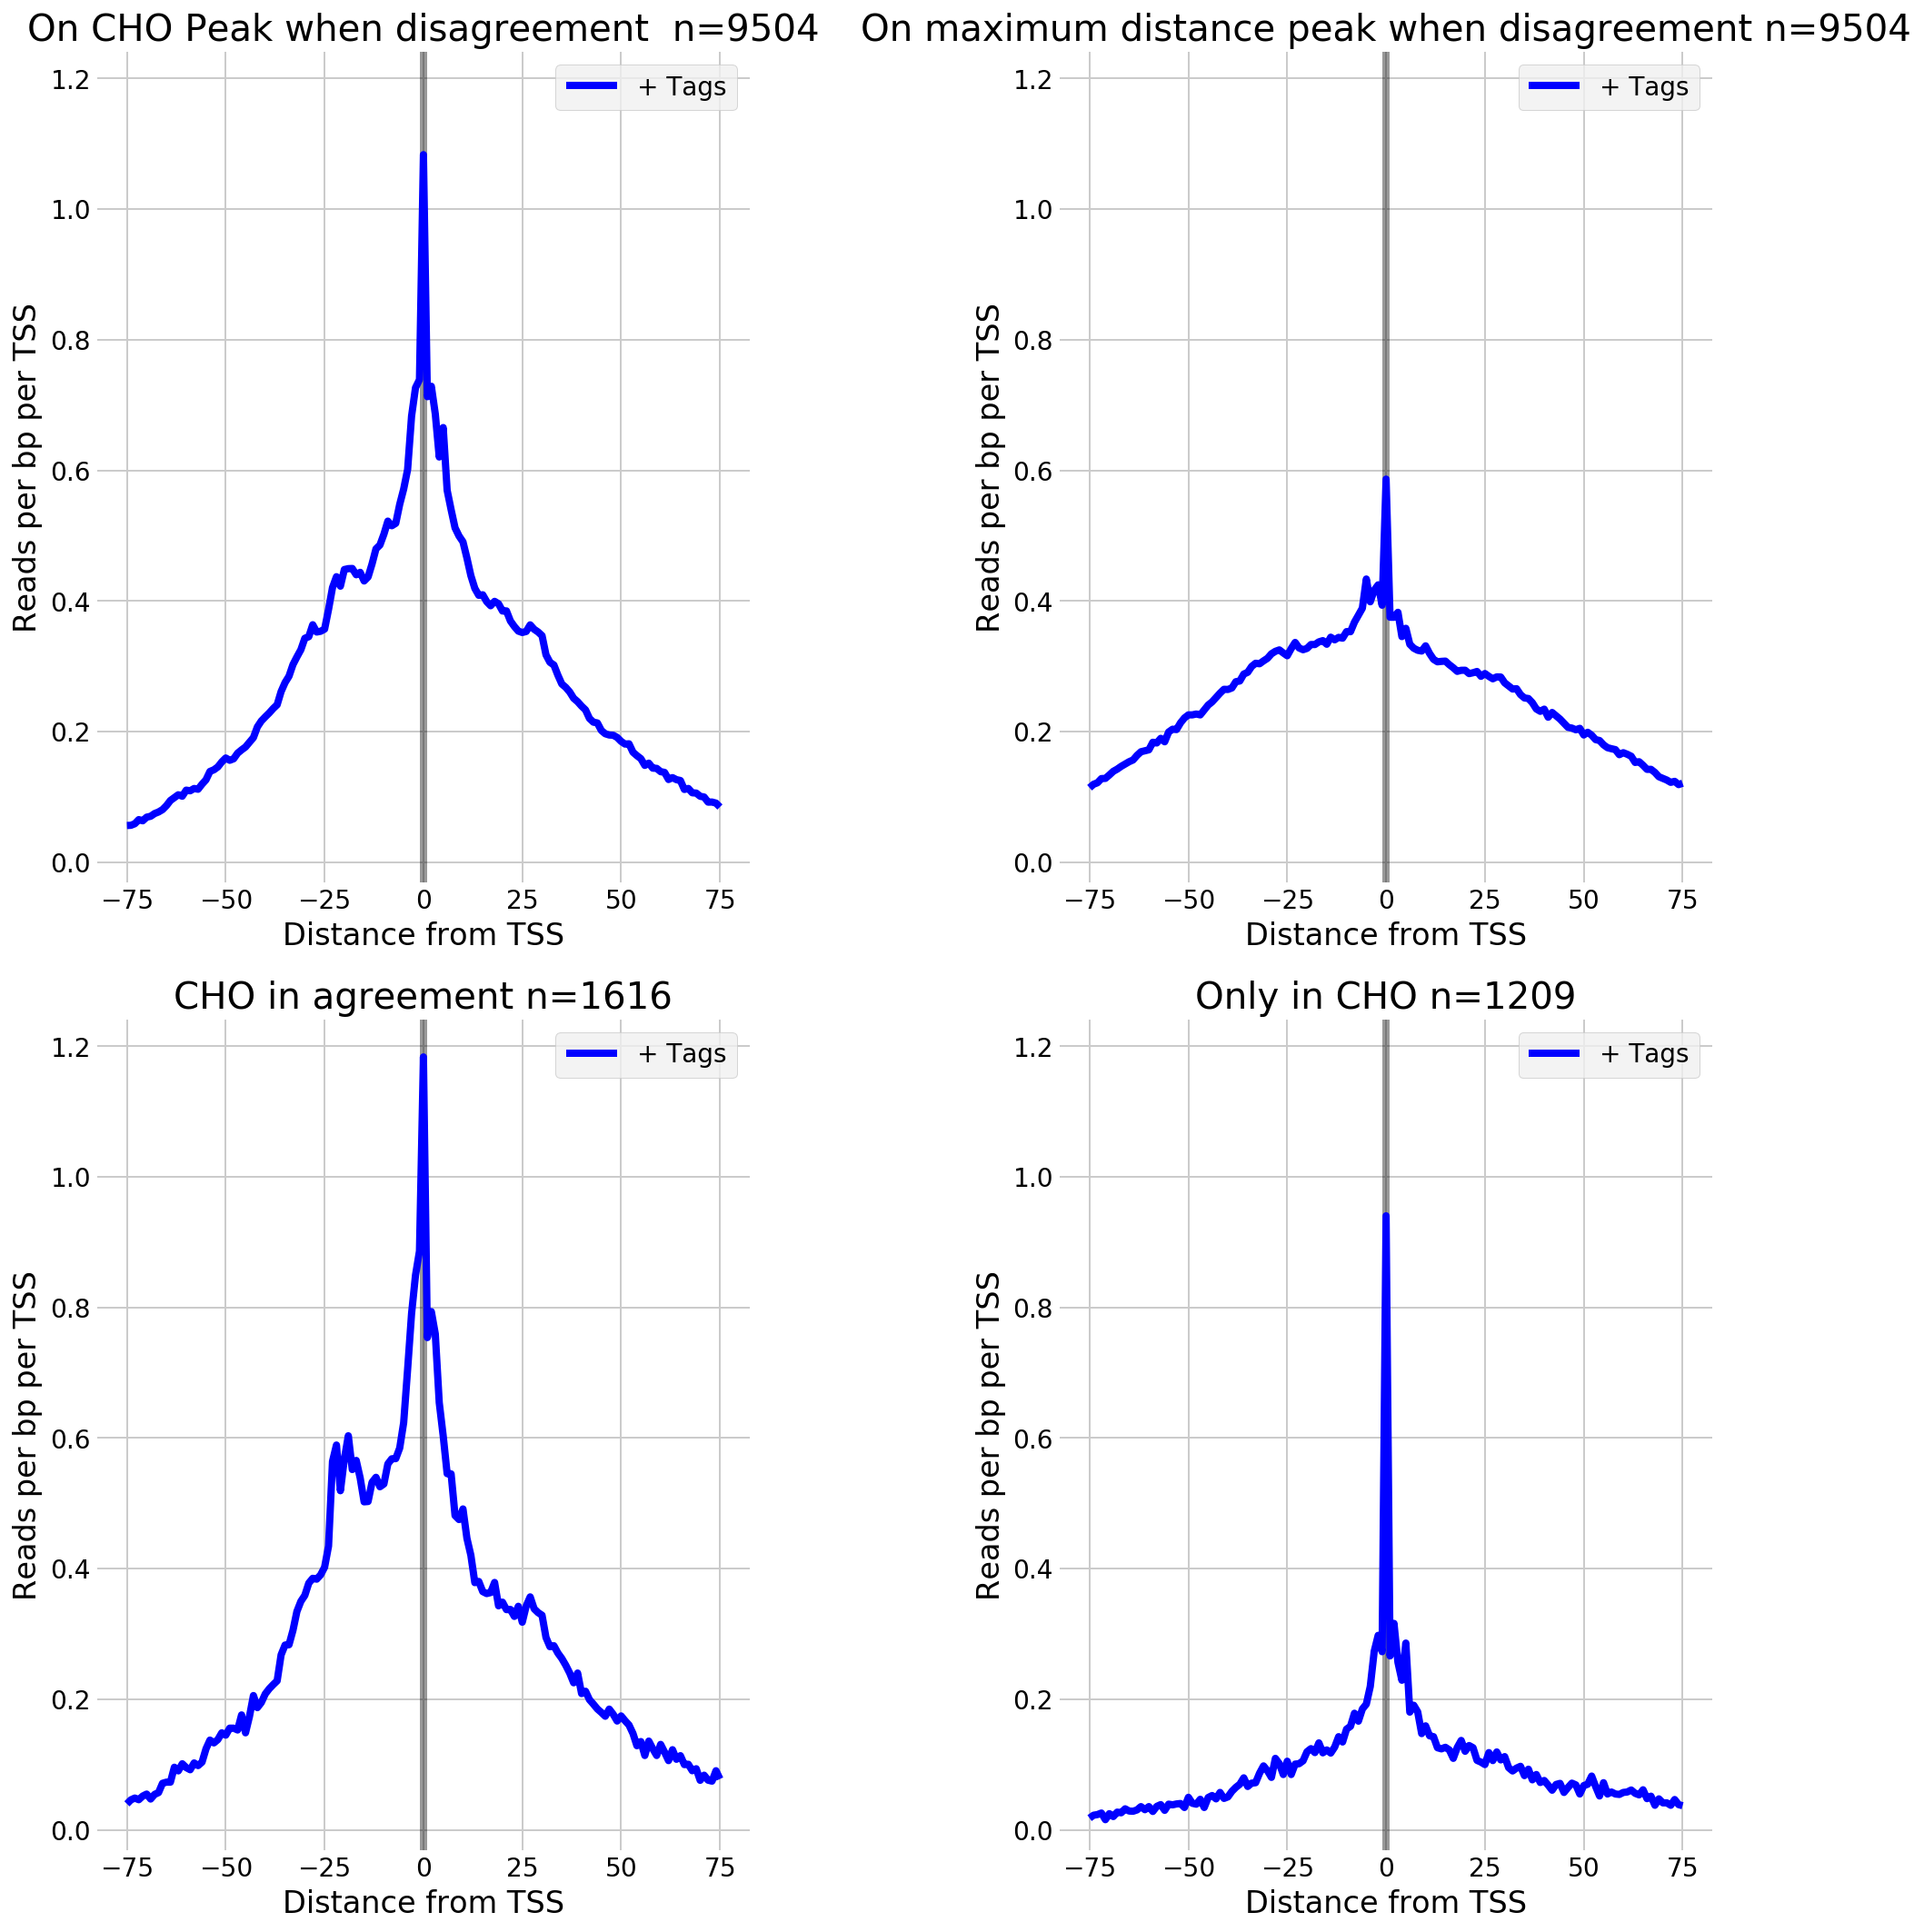

In [21]:
cho_dis3_maxDist_f = os.path.join(in_dir,"cho_disagree3_maxDistance_tol_0.tsv" )
cho_ag3_f = os.path.join(in_dir,"cho_agree3_tol_0.tsv" )
cho_dis3_f = os.path.join(in_dir,"cho_disagree3_tol_0.tsv" )
only_in_cho_f = os.path.join(in_dir, "cho_only_tol_0.tsv")


## Create RefSeq peak file for this
meta_f = "../Results/output/TSS1.exp.meta"

tissue = "CHO"
seq = "GROCap"
rep = "1"

tag_f = join(data_folder, tissue, seq, "f03_tags", "trim_" + tissue + "_" + seq + rep)


## 1.
hist_disagree3_maxDistance = join(save_dir,"hist_CHO_tags_disagree3_maxDistance_tol_0_reg150_res1")
hist(tag_f,hist_disagree3_maxDistance
     ,ref_fa,anno_gff,mode='peak',peak=cho_dis3_maxDist_f,region=150,res=1,pc=3,
    include_norm=False, include_heat=False)
n_disagree3_maxDistance = file_len(cho_dis3_maxDist_f) - 1

## 2. 
hist_cho_dis3 = join(save_dir,"hist_CHO_tags_cho_dis3_reg150_res1")
hist(tag_f,hist_cho_dis3,ref_fa,anno_gff,mode='peak',peak=cho_dis3_f,region=150,res=1,pc=3,
    include_norm=False, include_heat=False)
n_cho_dis3 = file_len(cho_dis3_f) - 1


## 3.
hist_cho_ag3 = join(save_dir,"hist_CHO_tags_cho_ag3_reg150_res1")
hist(tag_f,hist_cho_ag3,ref_fa,anno_gff,mode='peak',peak=cho_ag3_f,region=150,res=1,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_cho_ag3 = file_len(cho_ag3_f) - 1

hist_only_in_cho = join(save_dir,"hist_CHO_tags_only_in_cho_reg150_res1")
hist(tag_f,hist_only_in_cho,ref_fa,anno_gff,mode='peak',peak=only_in_cho_f,region=150,res=1,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_only_in_cho = file_len(only_in_cho_f) - 1

wrap_hist_plot([hist_cho_dis3, hist_disagree3_maxDistance, 
                hist_cho_ag3, hist_only_in_cho], hist_save=join(save_dir, "cho_tissues_tol0_reg150_res1_pc3"), 
                    names=["On CHO Peak when disagreement ","On maximum distance peak when disagreement", 
                          "CHO in agreement", "Only in CHO"], include_negative=False, n=[n_cho_dis3,n_disagree3_maxDistance,n_cho_ag3,n_only_in_cho], 
              xlims=None)


annotatePeaks.pl Results/histograms/compare_tissues/not_in_cho.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_not_in_cho_reg150_res1
Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_dis3_reg150_res1 [-82.5, 82.5] [0.02929456193353422, 1.090257301107764]
Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_0_reg150_res1 [-82.5, 82.5] [0.02929456193353422, 6.412954760652155]
Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_ag3_reg150_res1 [-82.5, 82.5] [-0.00205516248949638, 6.412954760652155]
Results/histograms/compare_tissues/Figures/hist_CHO_tags_not_in_cho_reg150_res1 [-82.5, 82.5] [-0.00205516248949638, 6.412954760652155]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

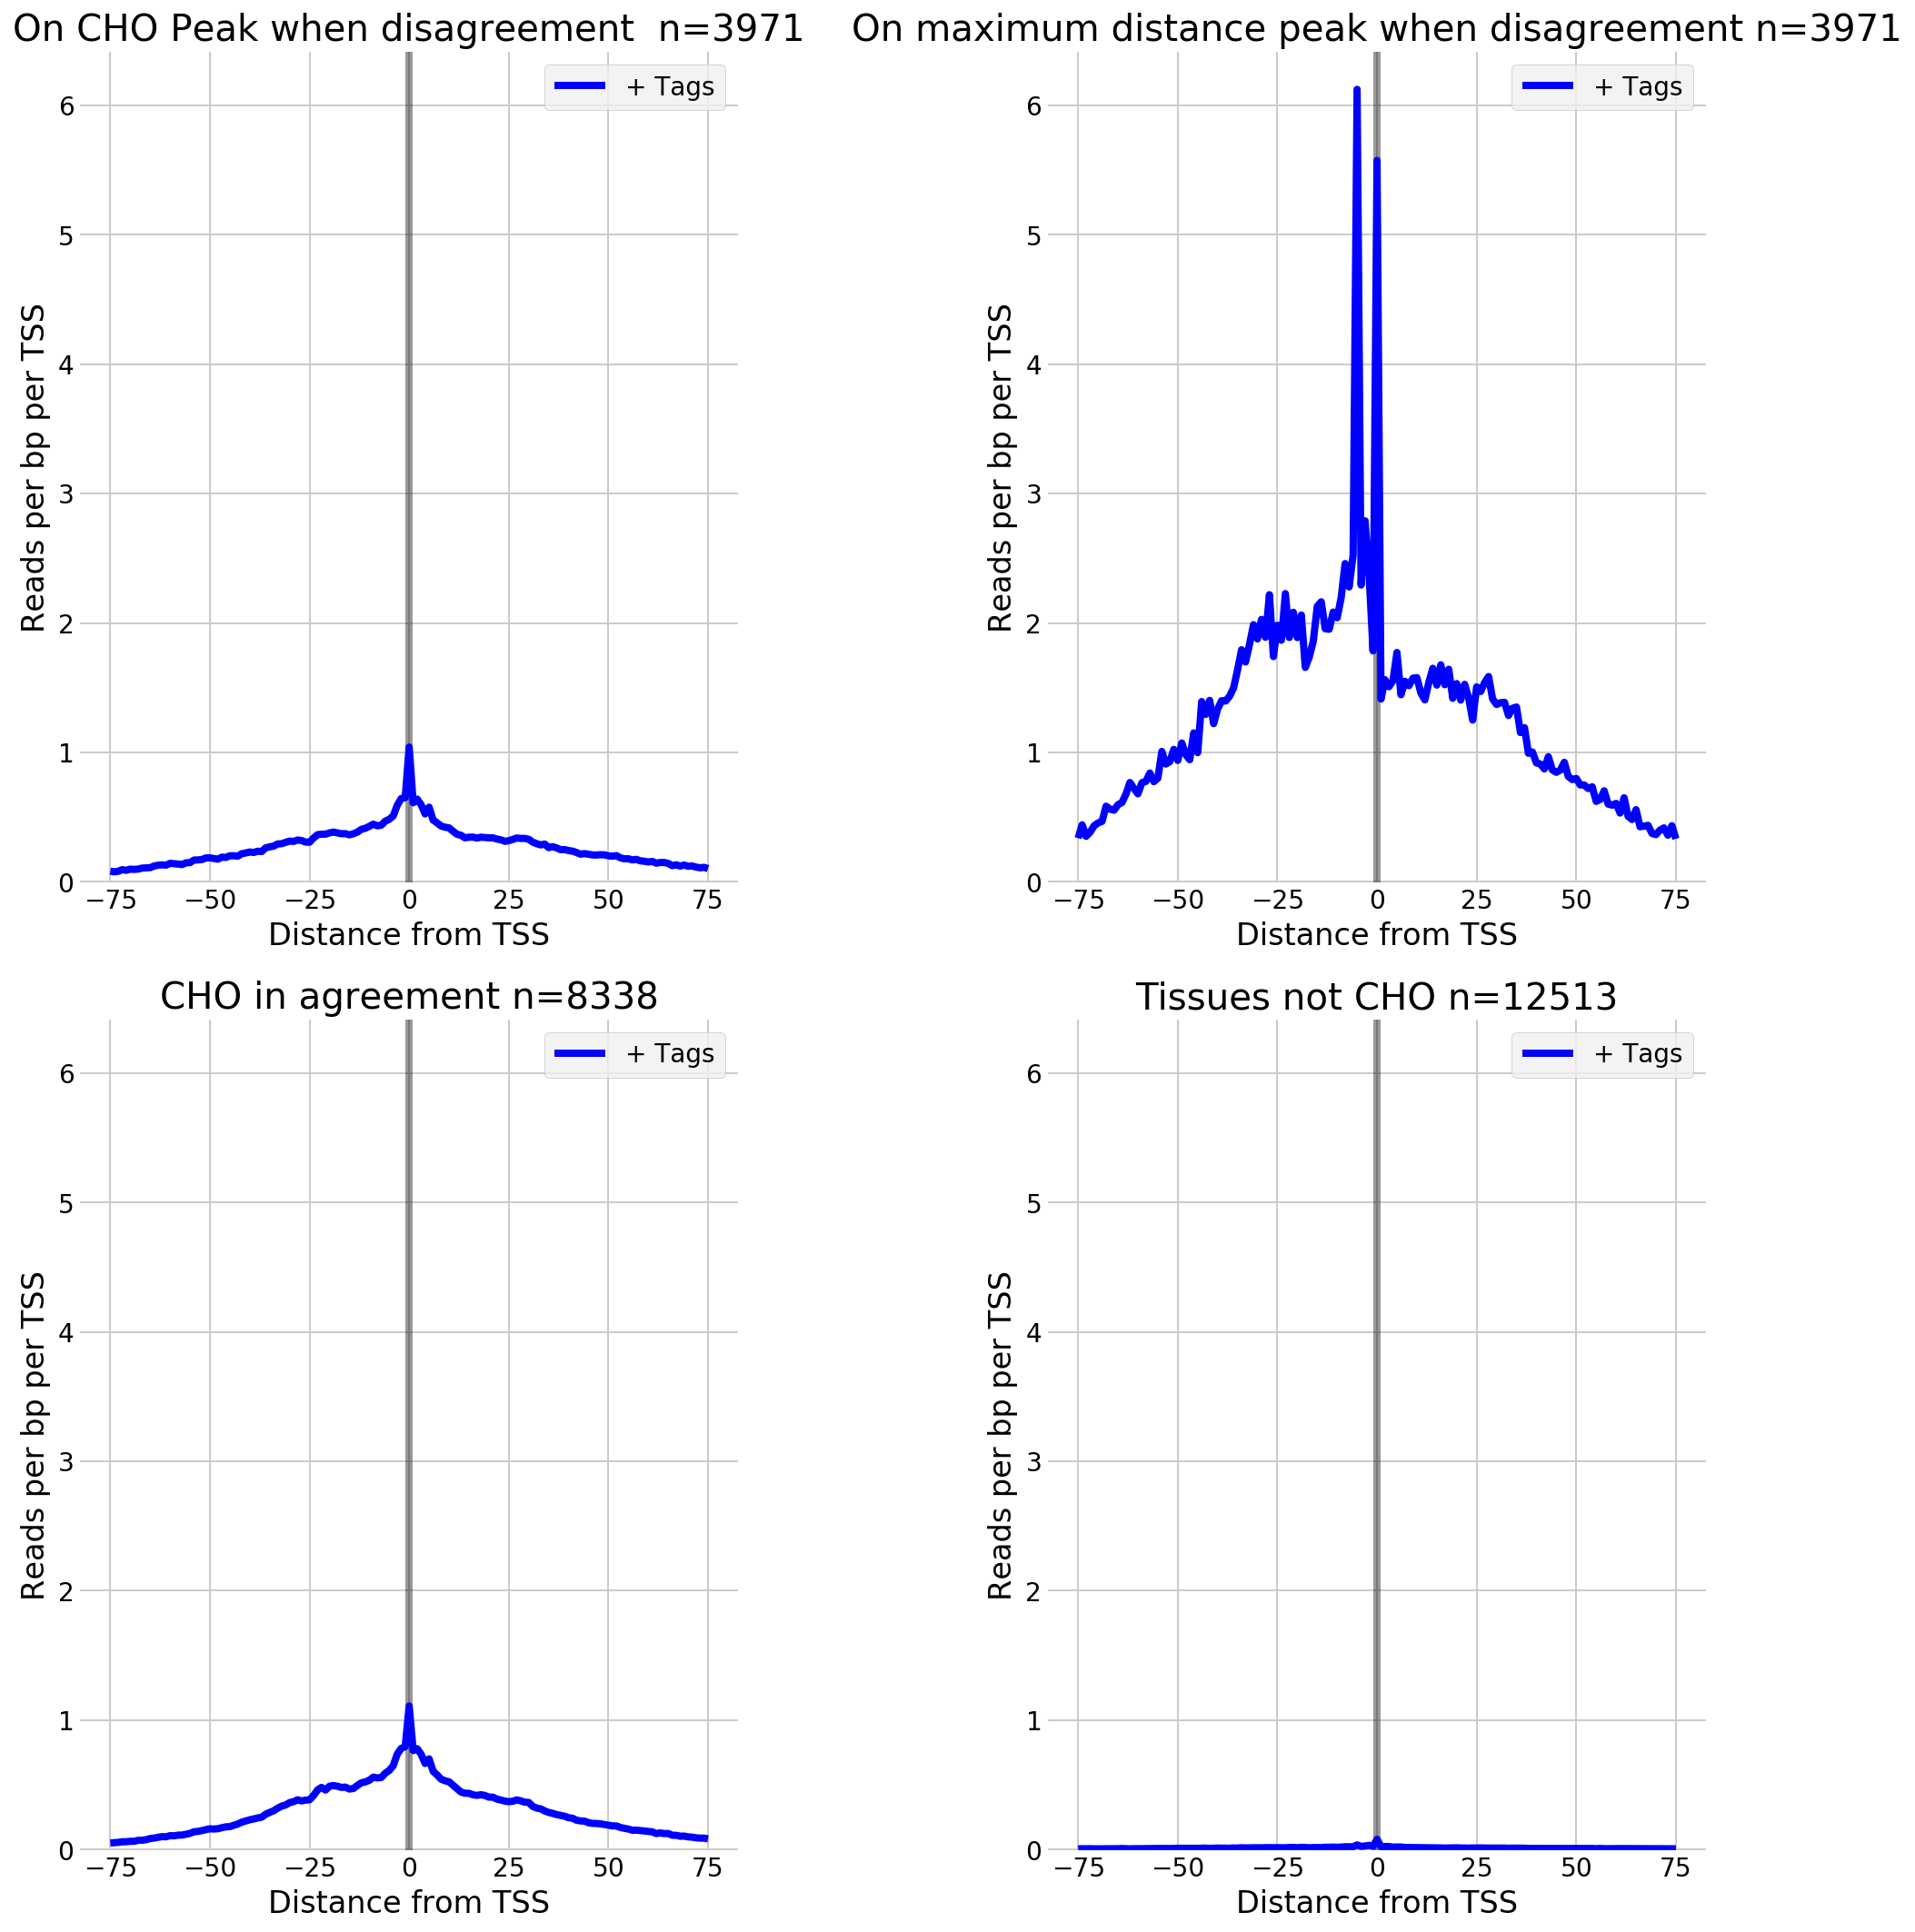

In [30]:
cho_dis3_maxDist_f = os.path.join(in_dir,"cho_disagree3_maxDistance_tol_0.tsv" )
cho_ag3_f = os.path.join(in_dir,"cho_agree3_tol_0.tsv" )
cho_dis3_f = os.path.join(in_dir,"cho_disagree3_tol_0.tsv" )
not_in_cho_f = os.path.join(in_dir, "not_in_cho.tsv")


## Create RefSeq peak file for this
meta_f = "../Results/output/TSS1.exp.meta"

tissue = "CHO"
seq = "GROCap"
rep = "1"
tag_f = join(data_folder, tissue, seq, "f03_tags", "trim_" + tissue + "_" + seq + rep)

## 1.
hist_disagree3_maxDistance = join(save_dir,"hist_CHO_tags_disagree3_maxDistance_tol_0_reg150_res1")
## 2. 
hist_cho_dis3 = join(save_dir,"hist_CHO_tags_cho_dis3_reg150_res1")
## 3.
hist_cho_ag3 = join(save_dir,"hist_CHO_tags_cho_ag3_reg150_res1")
## 4
hist_not_in_cho = join(save_dir,"hist_CHO_tags_not_in_cho_reg150_res1")
hist(tag_f,hist_not_in_cho,ref_fa,anno_gff,mode='peak',peak=not_in_cho_f,region=150,res=1,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_not_in_cho = file_len(not_in_cho_f) - 1

wrap_hist_plot([hist_cho_dis3, hist_disagree3_maxDistance, 
                hist_cho_ag3, hist_not_in_cho], hist_save=join(save_dir, "cho_tissues_not_in_cho_tol0_reg150_res1_pc3"), 
                    names=["On CHO Peak when disagreement ","On maximum distance peak when disagreement", 
                          "CHO in agreement", "Tissues not CHO"], include_negative=False, n=[n_cho_dis3,n_disagree3_maxDistance,n_cho_ag3,n_not_in_cho], 
              xlims=None)


# Tolerance 25 nt for agreement definition size=4kb res=25 pc=3

annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_maxDistance_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 4000 -hist 25 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_25
annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 4000 -hist 25 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_dis3
annotatePeaks.pl Results/histograms/compare_tissues/cho_agree3_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PIC

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


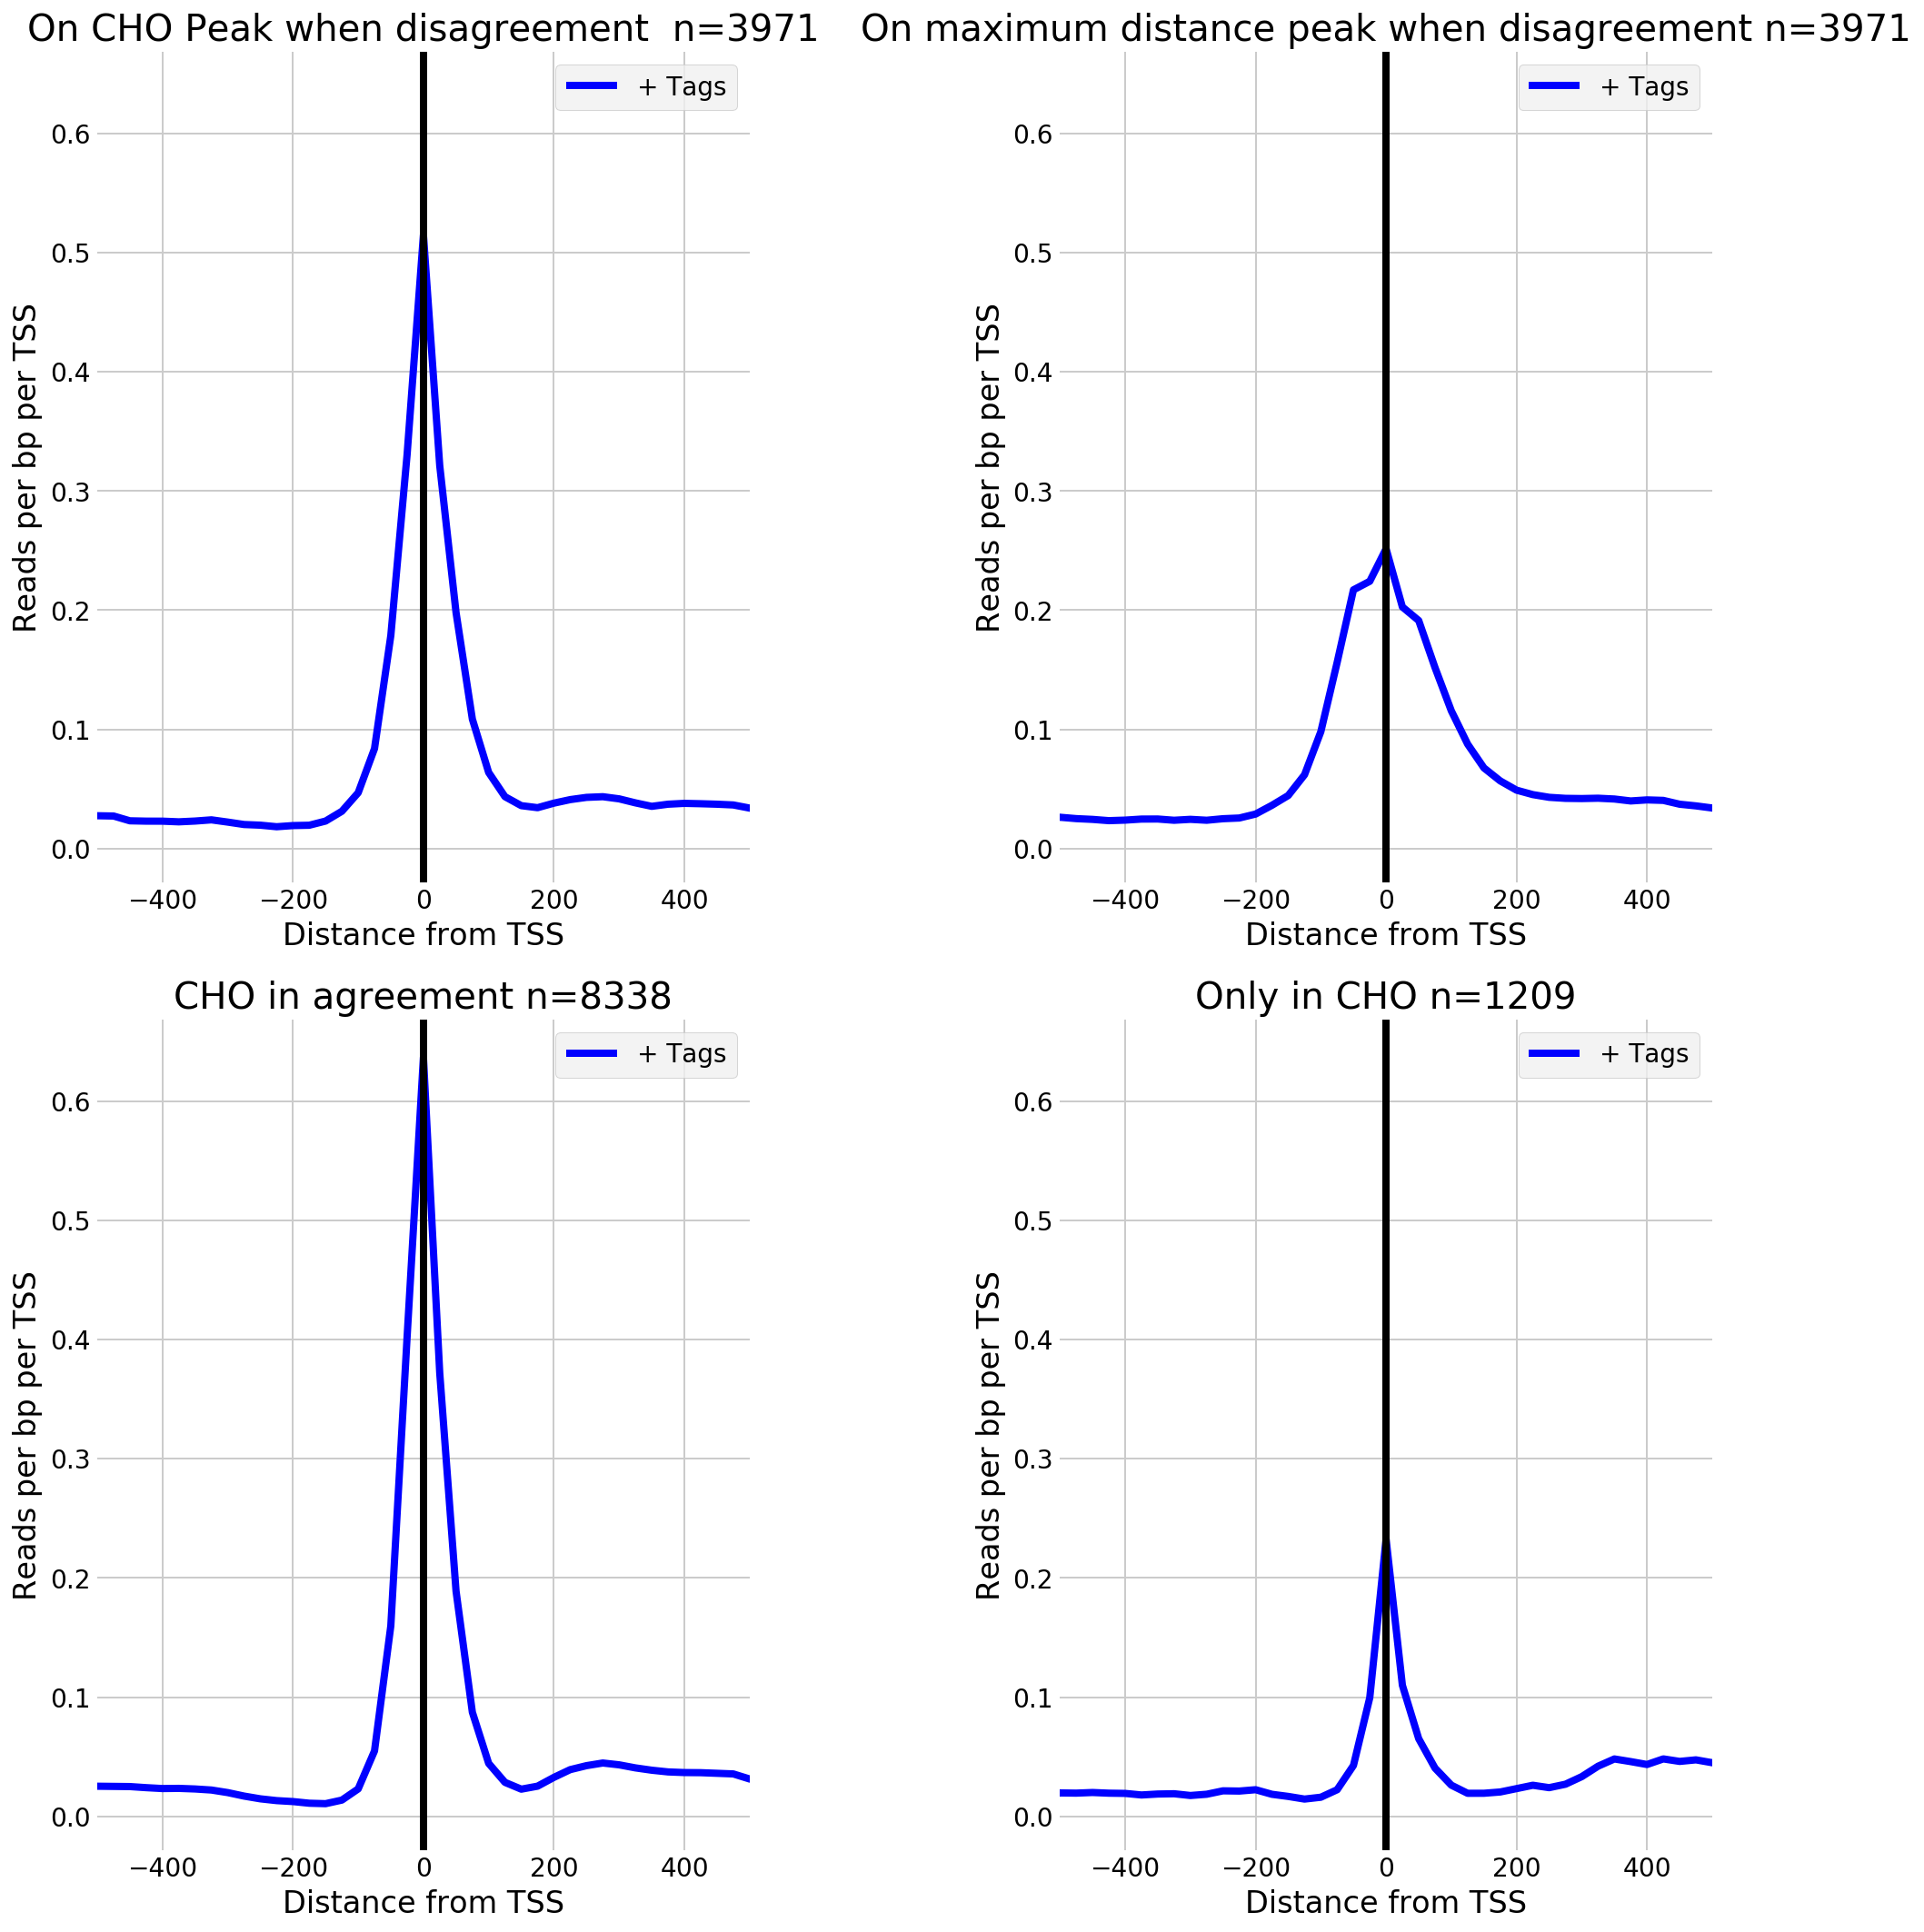

In [9]:
cho_dis3_maxDist_f = os.path.join(in_dir,"cho_disagree3_maxDistance_tol_25.tsv" )
cho_ag3_f = os.path.join(in_dir,"cho_agree3_tol_25.tsv" )
cho_dis3_f = os.path.join(in_dir,"cho_disagree3_tol_25.tsv" )
only_in_cho_f = os.path.join(in_dir, "cho_only_tol_25.tsv")


## Create RefSeq peak file for this
meta_f = "../Results/output/TSS1.exp.meta"

tissue = "CHO"
seq = "GROCap"
rep = "1"

tag_f = join(data_folder, tissue, seq, "f03_tags", "trim_" + tissue + "_" + seq + rep)


## 1.
hist_disagree3_maxDistance_tol_25 = join(save_dir,"hist_CHO_tags_disagree3_maxDistance_tol_25")

hist(tag_f,hist_disagree3_maxDistance_tol_25
     ,ref_fa,anno_gff,mode='peak',peak=cho_dis3_maxDist_f,region=4000,res=25,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)

n_disagree3_maxDistance_tol_25 = file_len(cho_dis3_maxDist_f) - 1

## 2. 
hist_cho_dis3 = join(save_dir,"hist_CHO_tags_cho_dis3")
hist(tag_f,hist_cho_dis3,ref_fa,anno_gff,mode='peak',peak=cho_dis3_f,region=4000,res=25,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_cho_dis3 = file_len(cho_dis3_f) - 1


## 3.
hist_cho_ag3 = join(save_dir,"hist_CHO_tags_cho_ag3")
hist(tag_f,hist_cho_ag3,ref_fa,anno_gff,mode='peak',peak=cho_ag3_f,region=4000,res=25,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_cho_ag3 = file_len(cho_ag3_f) - 1

hist_only_in_cho = join(save_dir,"hist_CHO_tags_only_in_cho")
hist(tag_f,hist_only_in_cho,ref_fa,anno_gff,mode='peak',peak=only_in_cho_f,region=4000,res=25,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_only_in_cho = file_len(only_in_cho_f) - 1

wrap_hist_plot([hist_cho_dis3,hist_disagree3_maxDistance_tol_25, hist_cho_ag3, hist_only_in_cho], hist_save=join(save_dir, "cho_tissues_tol25"), 
                    names=["On CHO Peak when disagreement ","On maximum distance peak when disagreement", 
                          "CHO in agreement", "Only in CHO"], include_negative=False, n=[n_cho_dis3,n_disagree3_maxDistance_tol_25,n_cho_ag3,n_only_in_cho])



# Tolerance 25 nt for agreement definition size=150 res=10 pc=3

annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_maxDistance_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 10 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_25_reg150_res10
annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 10 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_dis3_reg150_res10
annotatePeaks.pl Results/histograms/compare_tissues/cho_agree3_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GC

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


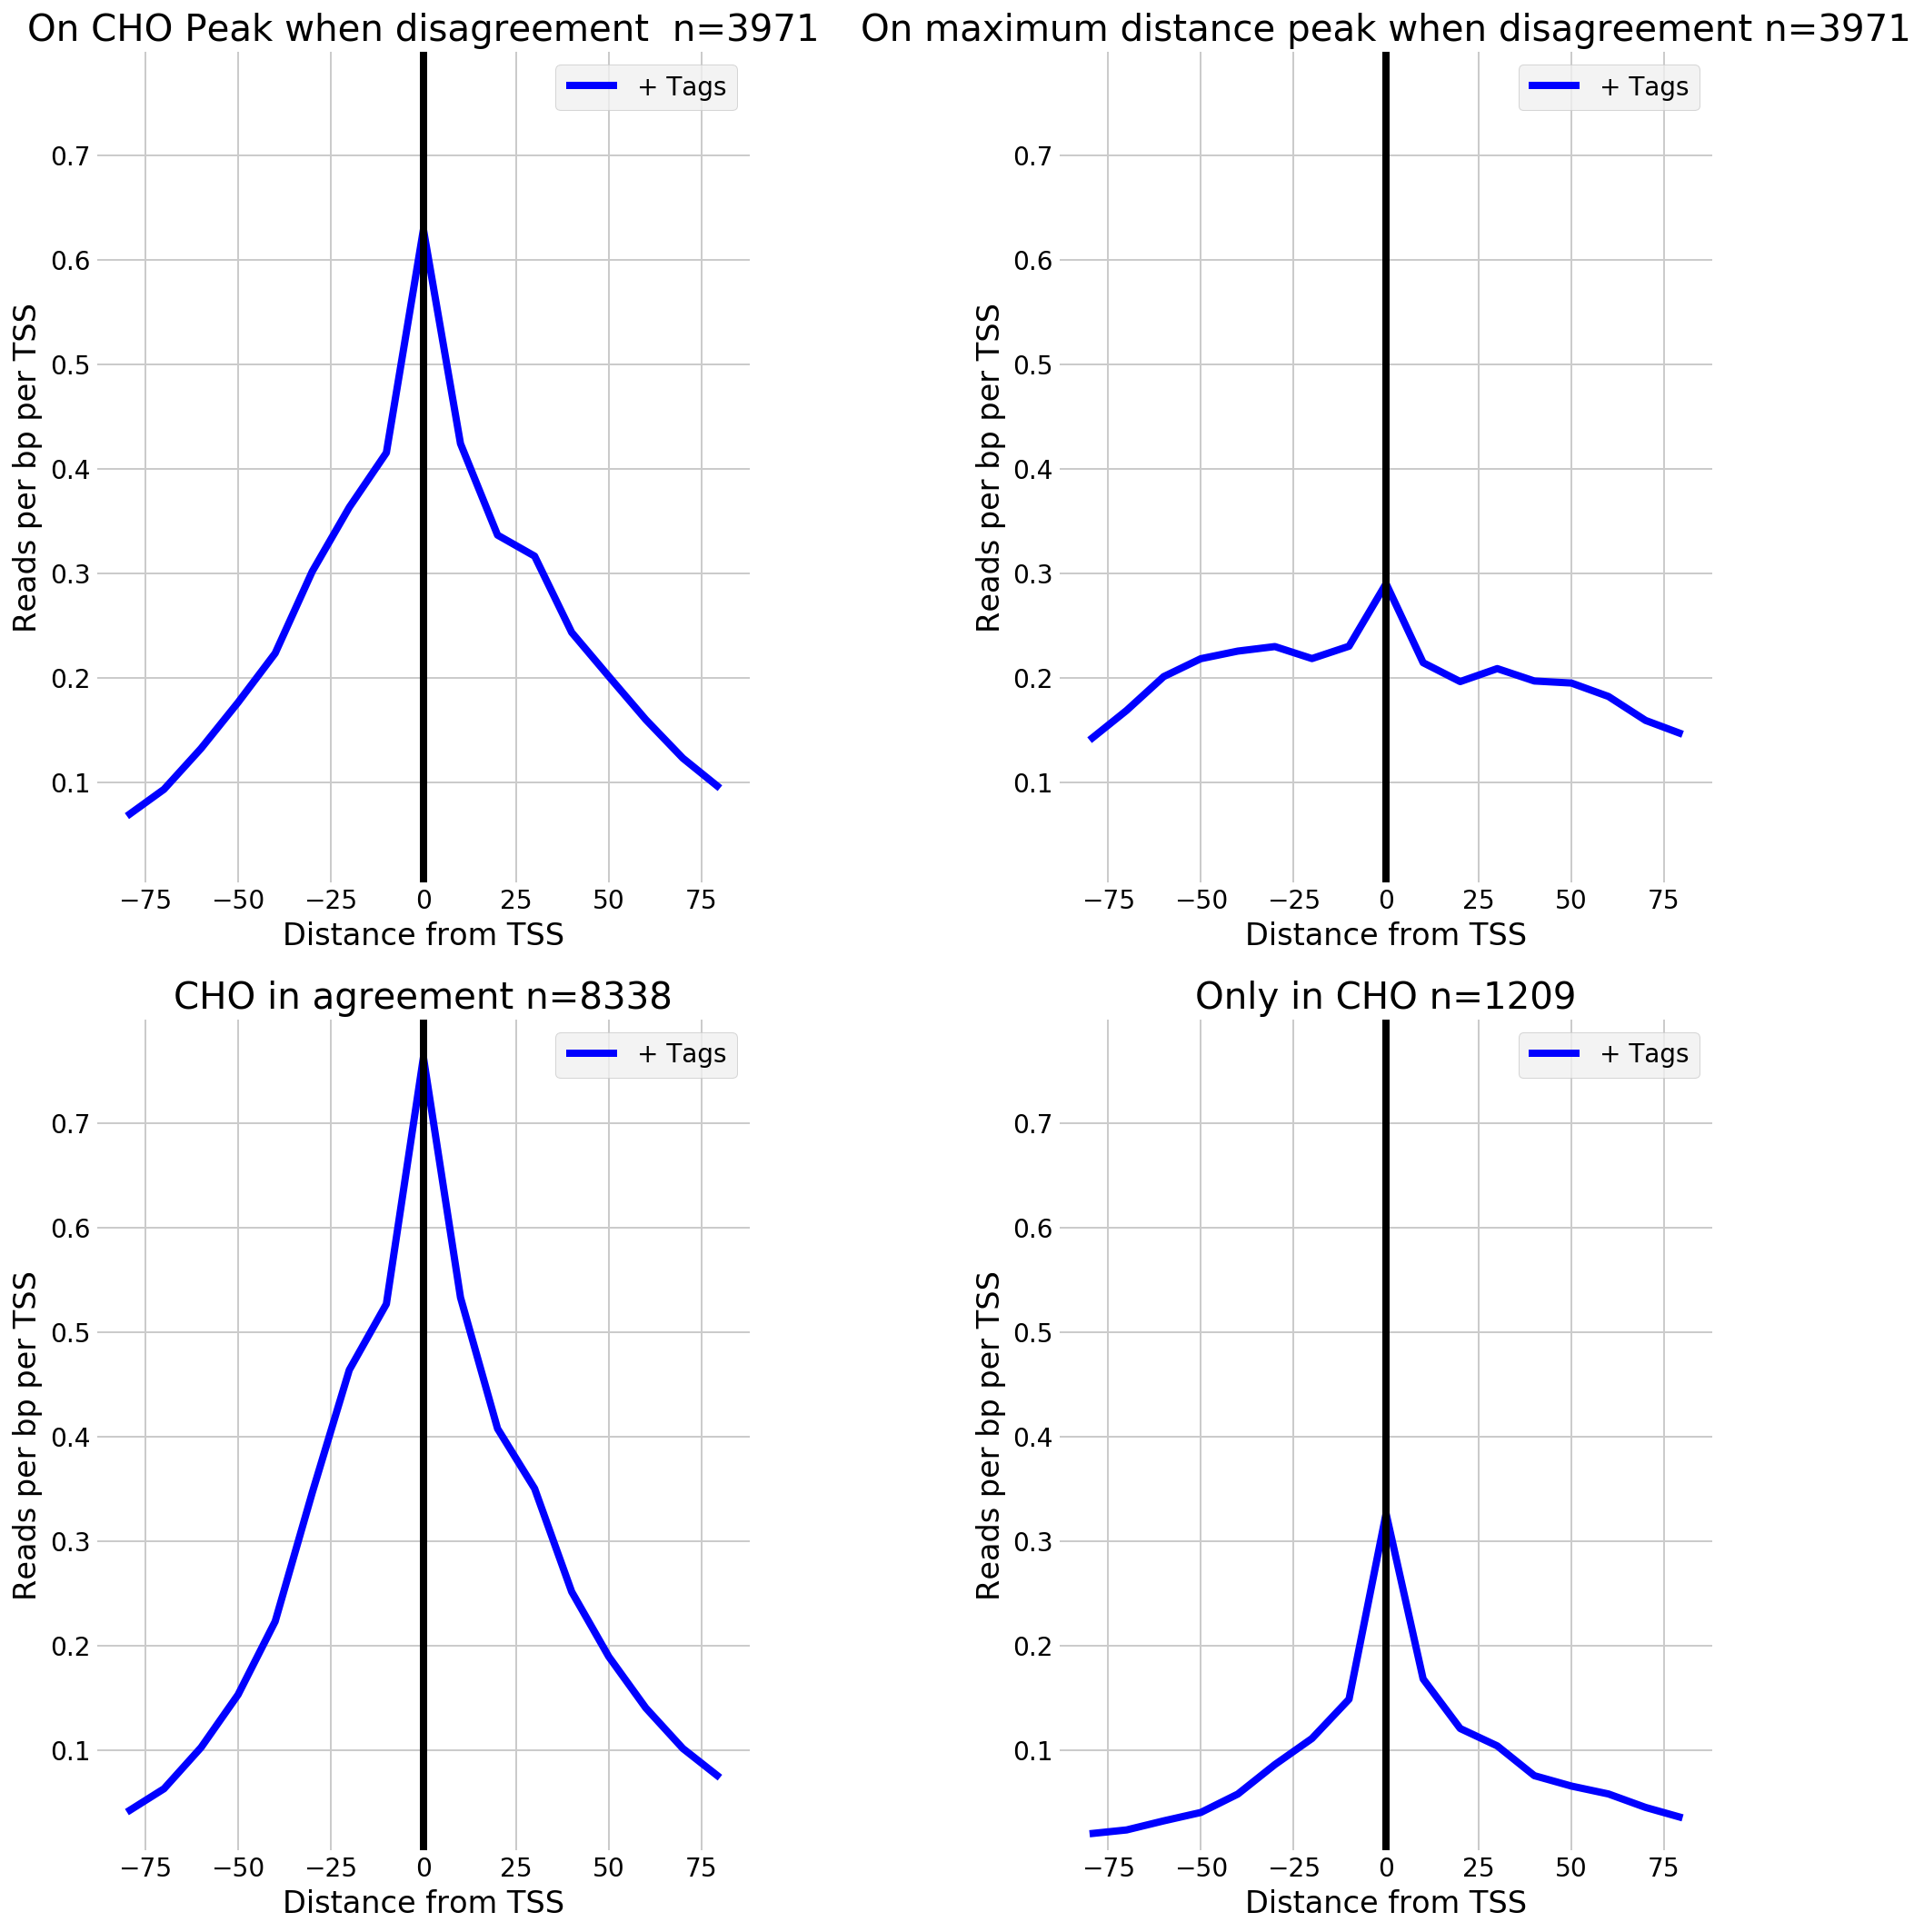

In [10]:
cho_dis3_maxDist_f = os.path.join(in_dir,"cho_disagree3_maxDistance_tol_25.tsv" )
cho_ag3_f = os.path.join(in_dir,"cho_agree3_tol_25.tsv" )
cho_dis3_f = os.path.join(in_dir,"cho_disagree3_tol_25.tsv" )
only_in_cho_f = os.path.join(in_dir, "cho_only_tol_25.tsv")


## Create RefSeq peak file for this
meta_f = "../Results/output/TSS1.exp.meta"

tissue = "CHO"
seq = "GROCap"
rep = "1"

tag_f = join(data_folder, tissue, seq, "f03_tags", "trim_" + tissue + "_" + seq + rep)


## 1.
hist_disagree3_maxDistance = join(save_dir,"hist_CHO_tags_disagree3_maxDistance_tol_25_reg150_res10")
hist(tag_f,hist_disagree3_maxDistance
     ,ref_fa,anno_gff,mode='peak',peak=cho_dis3_maxDist_f,region=150,res=10,pc=3,
    include_norm=False, include_heat=False)
n_disagree3_maxDistance = file_len(cho_dis3_maxDist_f) - 1

## 2. 
hist_cho_dis3 = join(save_dir,"hist_CHO_tags_cho_dis3_reg150_res10")
hist(tag_f,hist_cho_dis3,ref_fa,anno_gff,mode='peak',peak=cho_dis3_f,region=150,res=10,pc=3,
    include_norm=False, include_heat=False)
n_cho_dis3 = file_len(cho_dis3_f) - 1


## 3.
hist_cho_ag3 = join(save_dir,"hist_CHO_tags_cho_ag3_reg150_res10")
hist(tag_f,hist_cho_ag3,ref_fa,anno_gff,mode='peak',peak=cho_ag3_f,region=150,res=10,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_cho_ag3 = file_len(cho_ag3_f) - 1

hist_only_in_cho = join(save_dir,"hist_CHO_tags_only_in_cho_reg150_res10")
hist(tag_f,hist_only_in_cho,ref_fa,anno_gff,mode='peak',peak=only_in_cho_f,region=150,res=10,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_only_in_cho = file_len(only_in_cho_f) - 1

wrap_hist_plot([hist_cho_dis3, hist_disagree3_maxDistance, 
                hist_cho_ag3, hist_only_in_cho], hist_save=join(save_dir, "cho_tissues_tol25_reg150_res10"), 
                    names=["On CHO Peak when disagreement ","On maximum distance peak when disagreement", 
                          "CHO in agreement", "Only in CHO"], include_negative=False, n=[n_cho_dis3,n_disagree3_maxDistance,n_cho_ag3,n_only_in_cho], 
              xlims=None)


# Tolerance 25 nt for agreement definition size=150 res=1 pc=3

annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_maxDistance_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_25_reg150_res1
annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_dis3_reg150_res1
annotatePeaks.pl Results/histograms/compare_tissues/cho_agree3_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GCF_00

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

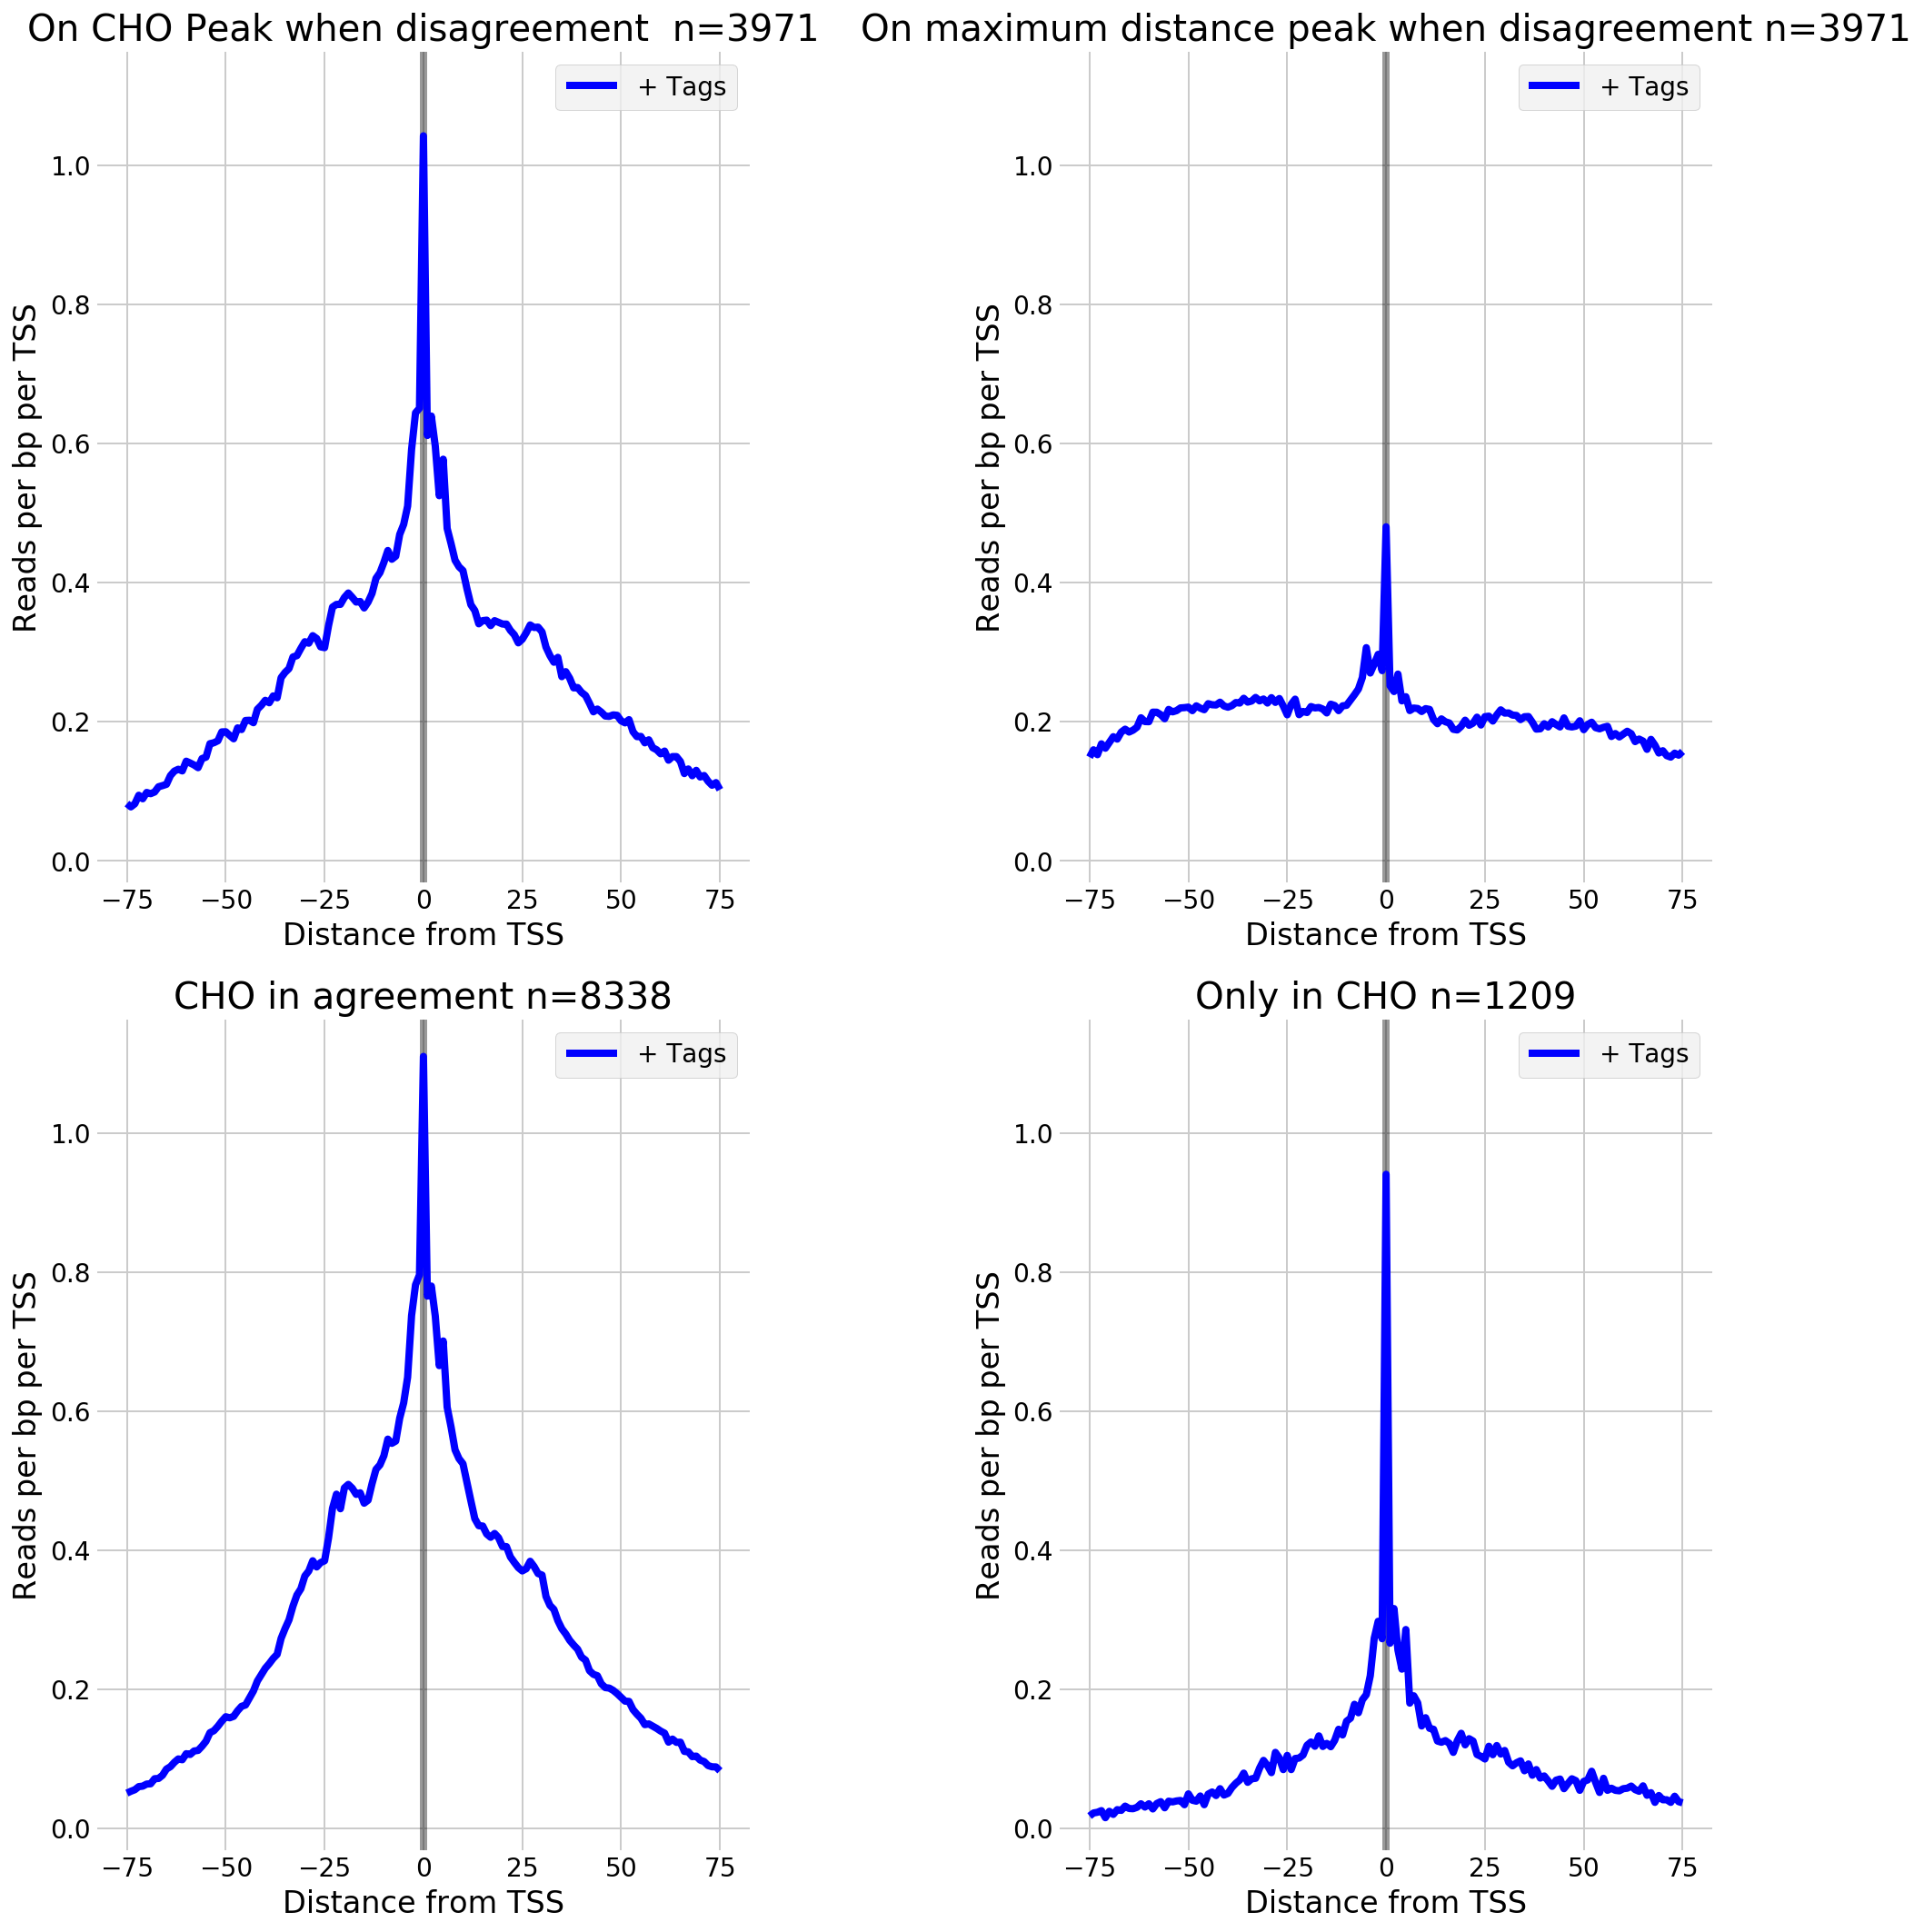

In [24]:
cho_dis3_maxDist_f = os.path.join(in_dir,"cho_disagree3_maxDistance_tol_25.tsv" )
cho_ag3_f = os.path.join(in_dir,"cho_agree3_tol_25.tsv" )
cho_dis3_f = os.path.join(in_dir,"cho_disagree3_tol_25.tsv" )
only_in_cho_f = os.path.join(in_dir, "cho_only_tol_25.tsv")


## Create RefSeq peak file for this
meta_f = "../Results/output/TSS1.exp.meta"

tissue = "CHO"
seq = "GROCap"
rep = "1"

tag_f = join(data_folder, tissue, seq, "f03_tags", "trim_" + tissue + "_" + seq + rep)


## 1.
hist_disagree3_maxDistance = join(save_dir,"hist_CHO_tags_disagree3_maxDistance_tol_25_reg150_res1")
hist(tag_f,hist_disagree3_maxDistance
     ,ref_fa,anno_gff,mode='peak',peak=cho_dis3_maxDist_f,region=150,res=1,pc=3,
    include_norm=False, include_heat=False)
n_disagree3_maxDistance = file_len(cho_dis3_maxDist_f) - 1

## 2. 
hist_cho_dis3 = join(save_dir,"hist_CHO_tags_cho_dis3_reg150_res1")
hist(tag_f,hist_cho_dis3,ref_fa,anno_gff,mode='peak',peak=cho_dis3_f,region=150,res=1,pc=3,
    include_norm=False, include_heat=False)
n_cho_dis3 = file_len(cho_dis3_f) - 1


## 3.
hist_cho_ag3 = join(save_dir,"hist_CHO_tags_cho_ag3_reg150_res1")
hist(tag_f,hist_cho_ag3,ref_fa,anno_gff,mode='peak',peak=cho_ag3_f,region=150,res=1,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_cho_ag3 = file_len(cho_ag3_f) - 1

hist_only_in_cho = join(save_dir,"hist_CHO_tags_only_in_cho_reg150_res1")
hist(tag_f,hist_only_in_cho,ref_fa,anno_gff,mode='peak',peak=only_in_cho_f,region=150,res=1,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_only_in_cho = file_len(only_in_cho_f) - 1

wrap_hist_plot([hist_cho_dis3, hist_disagree3_maxDistance, 
                hist_cho_ag3, hist_only_in_cho], hist_save=join(save_dir, "cho_tissues_tol25_reg150_res1"), 
                    names=["On CHO Peak when disagreement ","On maximum distance peak when disagreement", 
                          "CHO in agreement", "Only in CHO"], include_negative=False, n=[n_cho_dis3,n_disagree3_maxDistance,n_cho_ag3,n_only_in_cho], 
              xlims=None)


# Tolerance 25 nt for agreement definition size=150 res=10 no pc

annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_maxDistance_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 0 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_25_reg150_res1_nopc
annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 0 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_dis3_reg150_res1_nopc
annotatePeaks.pl Results/histograms/compare_tissues/cho_agree3_tol_25.tsv /data/isshamie/genome/ncbi_anno_

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

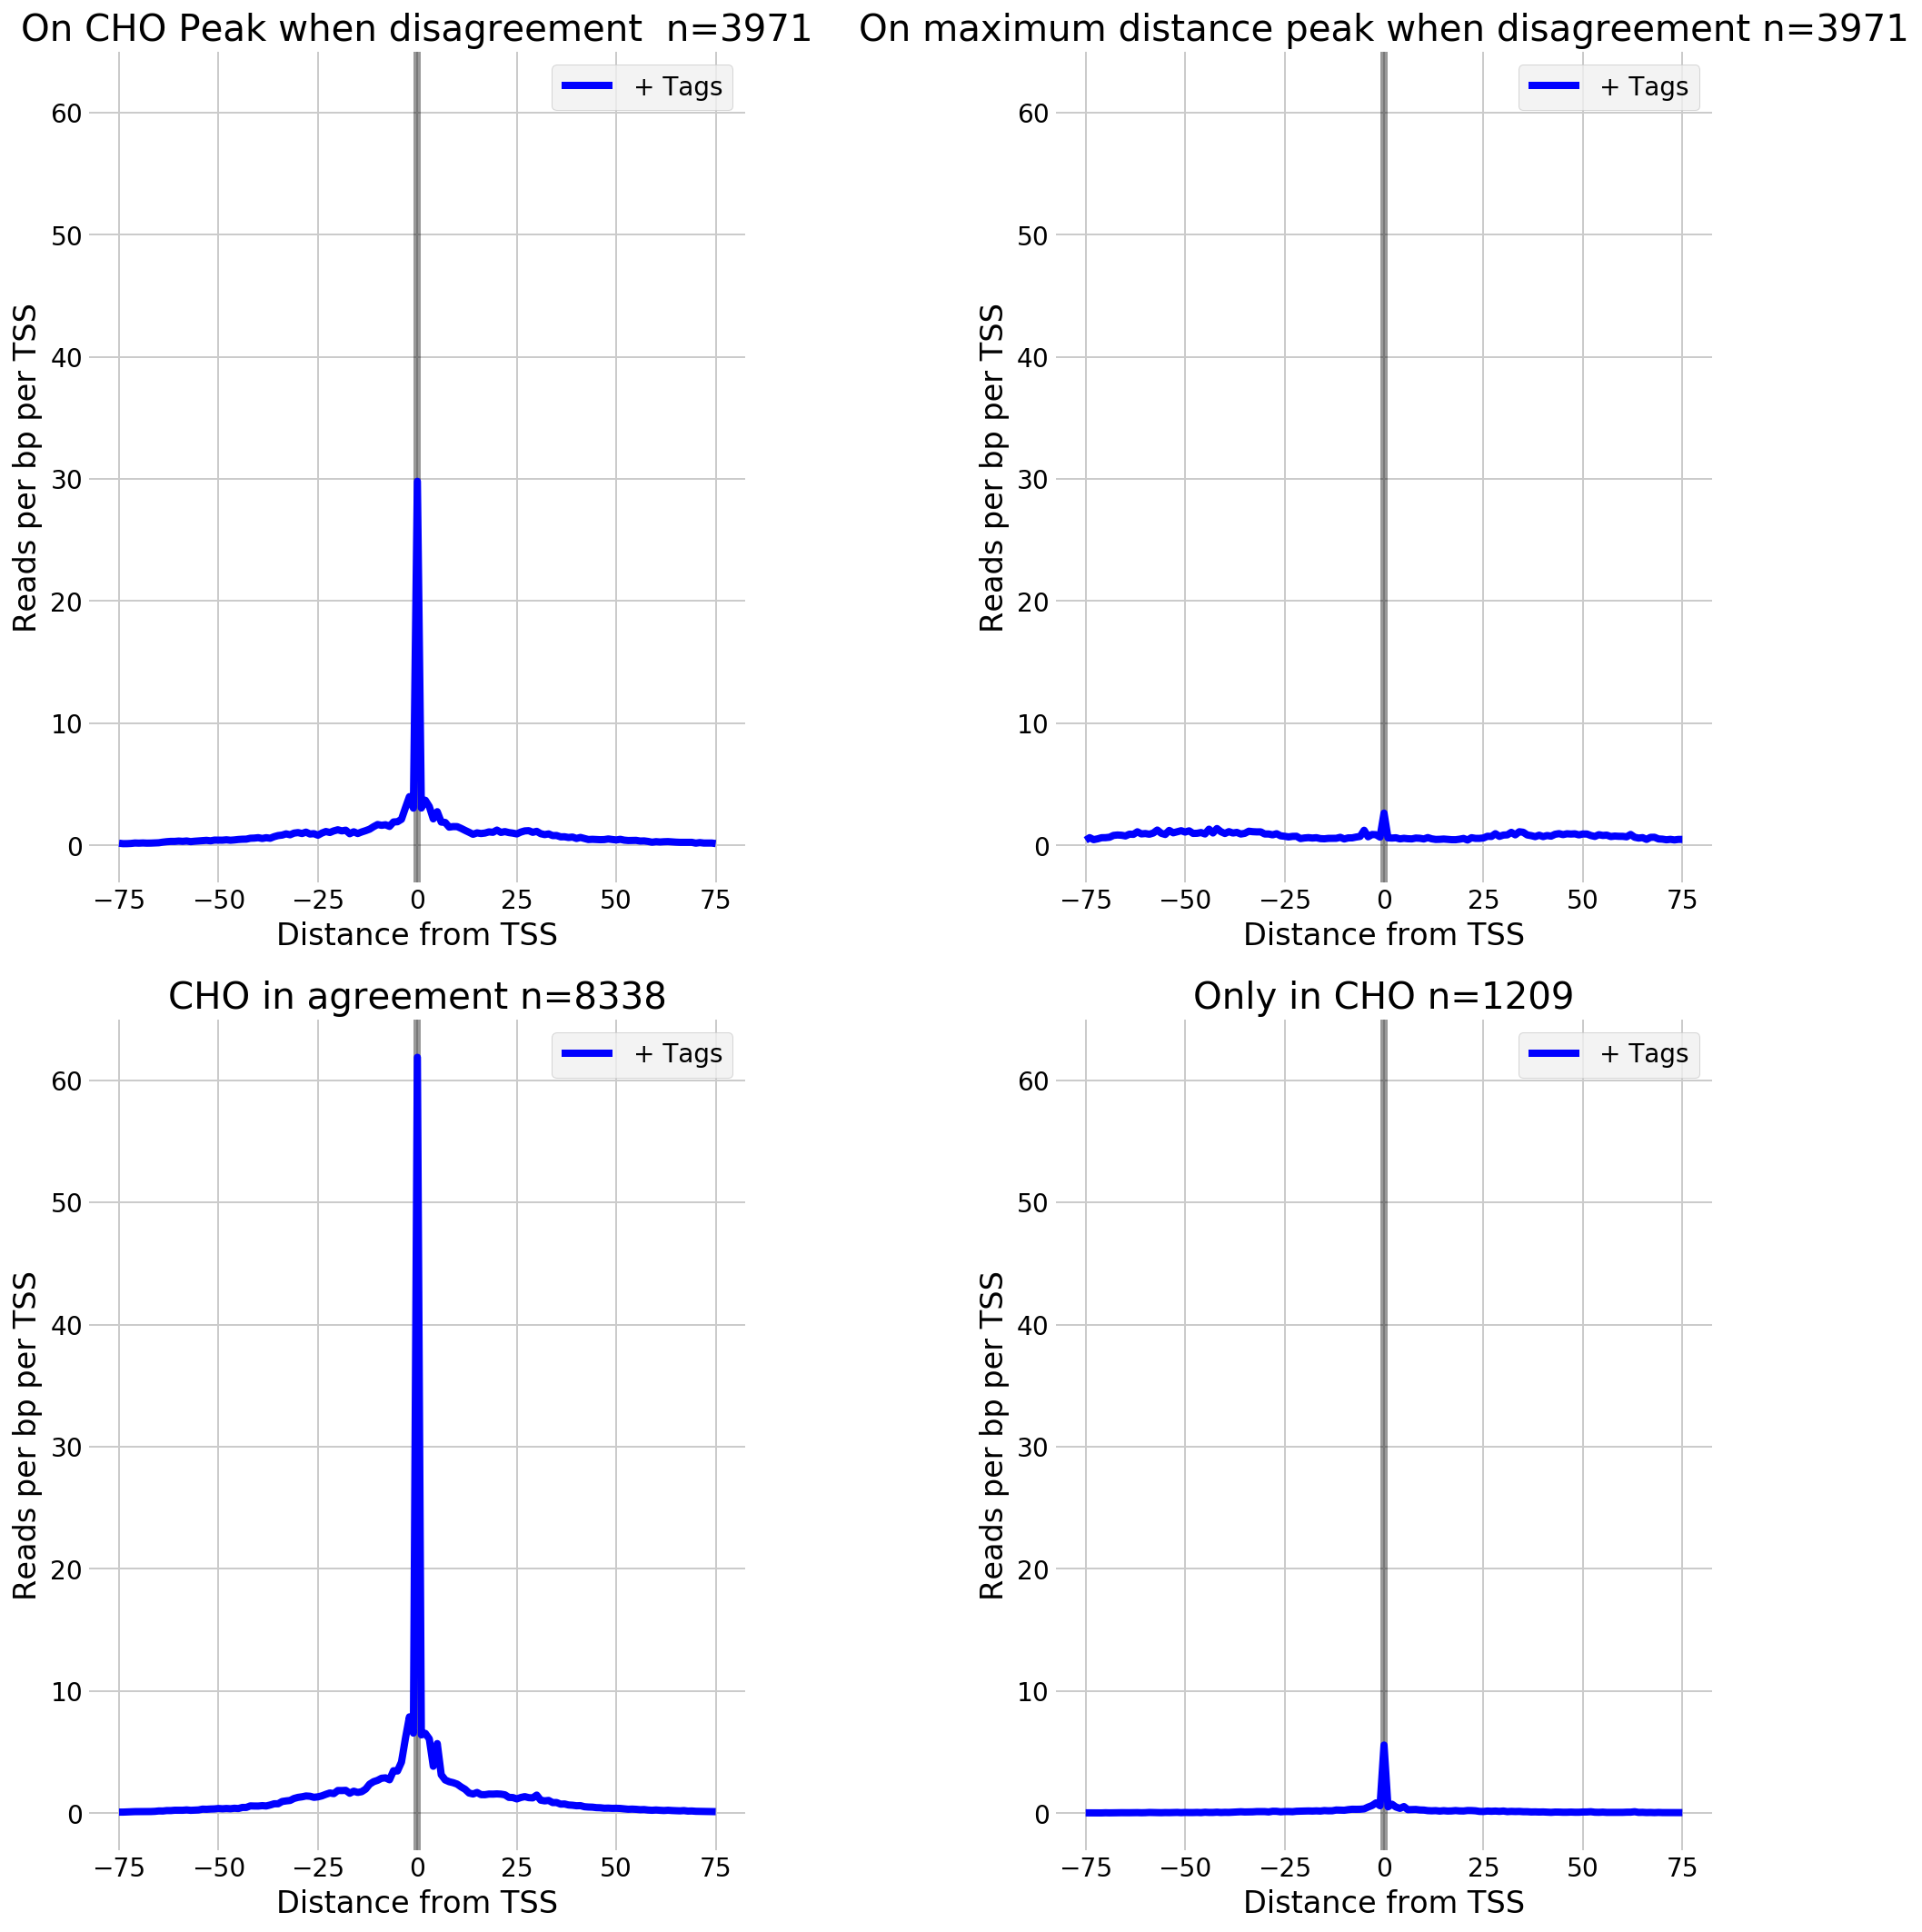

In [25]:
cho_dis3_maxDist_f = os.path.join(in_dir,"cho_disagree3_maxDistance_tol_25.tsv" )
cho_ag3_f = os.path.join(in_dir,"cho_agree3_tol_25.tsv" )
cho_dis3_f = os.path.join(in_dir,"cho_disagree3_tol_25.tsv" )
only_in_cho_f = os.path.join(in_dir, "cho_only_tol_25.tsv")


## Create RefSeq peak file for this
meta_f = "../Results/output/TSS1.exp.meta"

tissue = "CHO"
seq = "GROCap"
rep = "1"

tag_f = join(data_folder, tissue, seq, "f03_tags", "trim_" + tissue + "_" + seq + rep)


## 1.
hist_disagree3_maxDistance = join(save_dir,"hist_CHO_tags_disagree3_maxDistance_tol_25_reg150_res1_nopc")
hist(tag_f,hist_disagree3_maxDistance
     ,ref_fa,anno_gff,mode='peak',peak=cho_dis3_maxDist_f,region=150,res=1,
    include_norm=False, include_heat=False)
n_disagree3_maxDistance = file_len(cho_dis3_maxDist_f) - 1

## 2. 
hist_cho_dis3 = join(save_dir,"hist_CHO_tags_cho_dis3_reg150_res1_nopc")
hist(tag_f,hist_cho_dis3,ref_fa,anno_gff,mode='peak',peak=cho_dis3_f,region=150,res=1,
    include_norm=False, include_heat=False)
n_cho_dis3 = file_len(cho_dis3_f) - 1


## 3.
hist_cho_ag3 = join(save_dir,"hist_CHO_tags_cho_ag3_reg150_res1_nopc")
hist(tag_f,hist_cho_ag3,ref_fa,anno_gff,mode='peak',peak=cho_ag3_f,region=150,res=1,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_cho_ag3 = file_len(cho_ag3_f) - 1

hist_only_in_cho = join(save_dir,"hist_CHO_tags_only_in_cho_reg150_res1_nopc")
hist(tag_f,hist_only_in_cho,ref_fa,anno_gff,mode='peak',peak=only_in_cho_f,region=150,res=1,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_only_in_cho = file_len(only_in_cho_f) - 1

wrap_hist_plot([hist_cho_dis3, hist_disagree3_maxDistance, 
                hist_cho_ag3, hist_only_in_cho], hist_save=join(save_dir, "cho_tissues_tol25_reg150_res1_nopc"), 
                    names=["On CHO Peak when disagreement ","On maximum distance peak when disagreement", 
                          "CHO in agreement", "Only in CHO"], include_negative=False, n=[n_cho_dis3,n_disagree3_maxDistance,n_cho_ag3,n_only_in_cho], 
              xlims=None)


annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_maxDistance_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 10 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_25_reg150_res10
annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 10 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 3 > Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_dis3_reg150_res10
annotatePeaks.pl Results/histograms/compare_tissues/cho_agree3_tol_25.tsv /data/isshamie/genome/ncbi_anno_103/GC

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


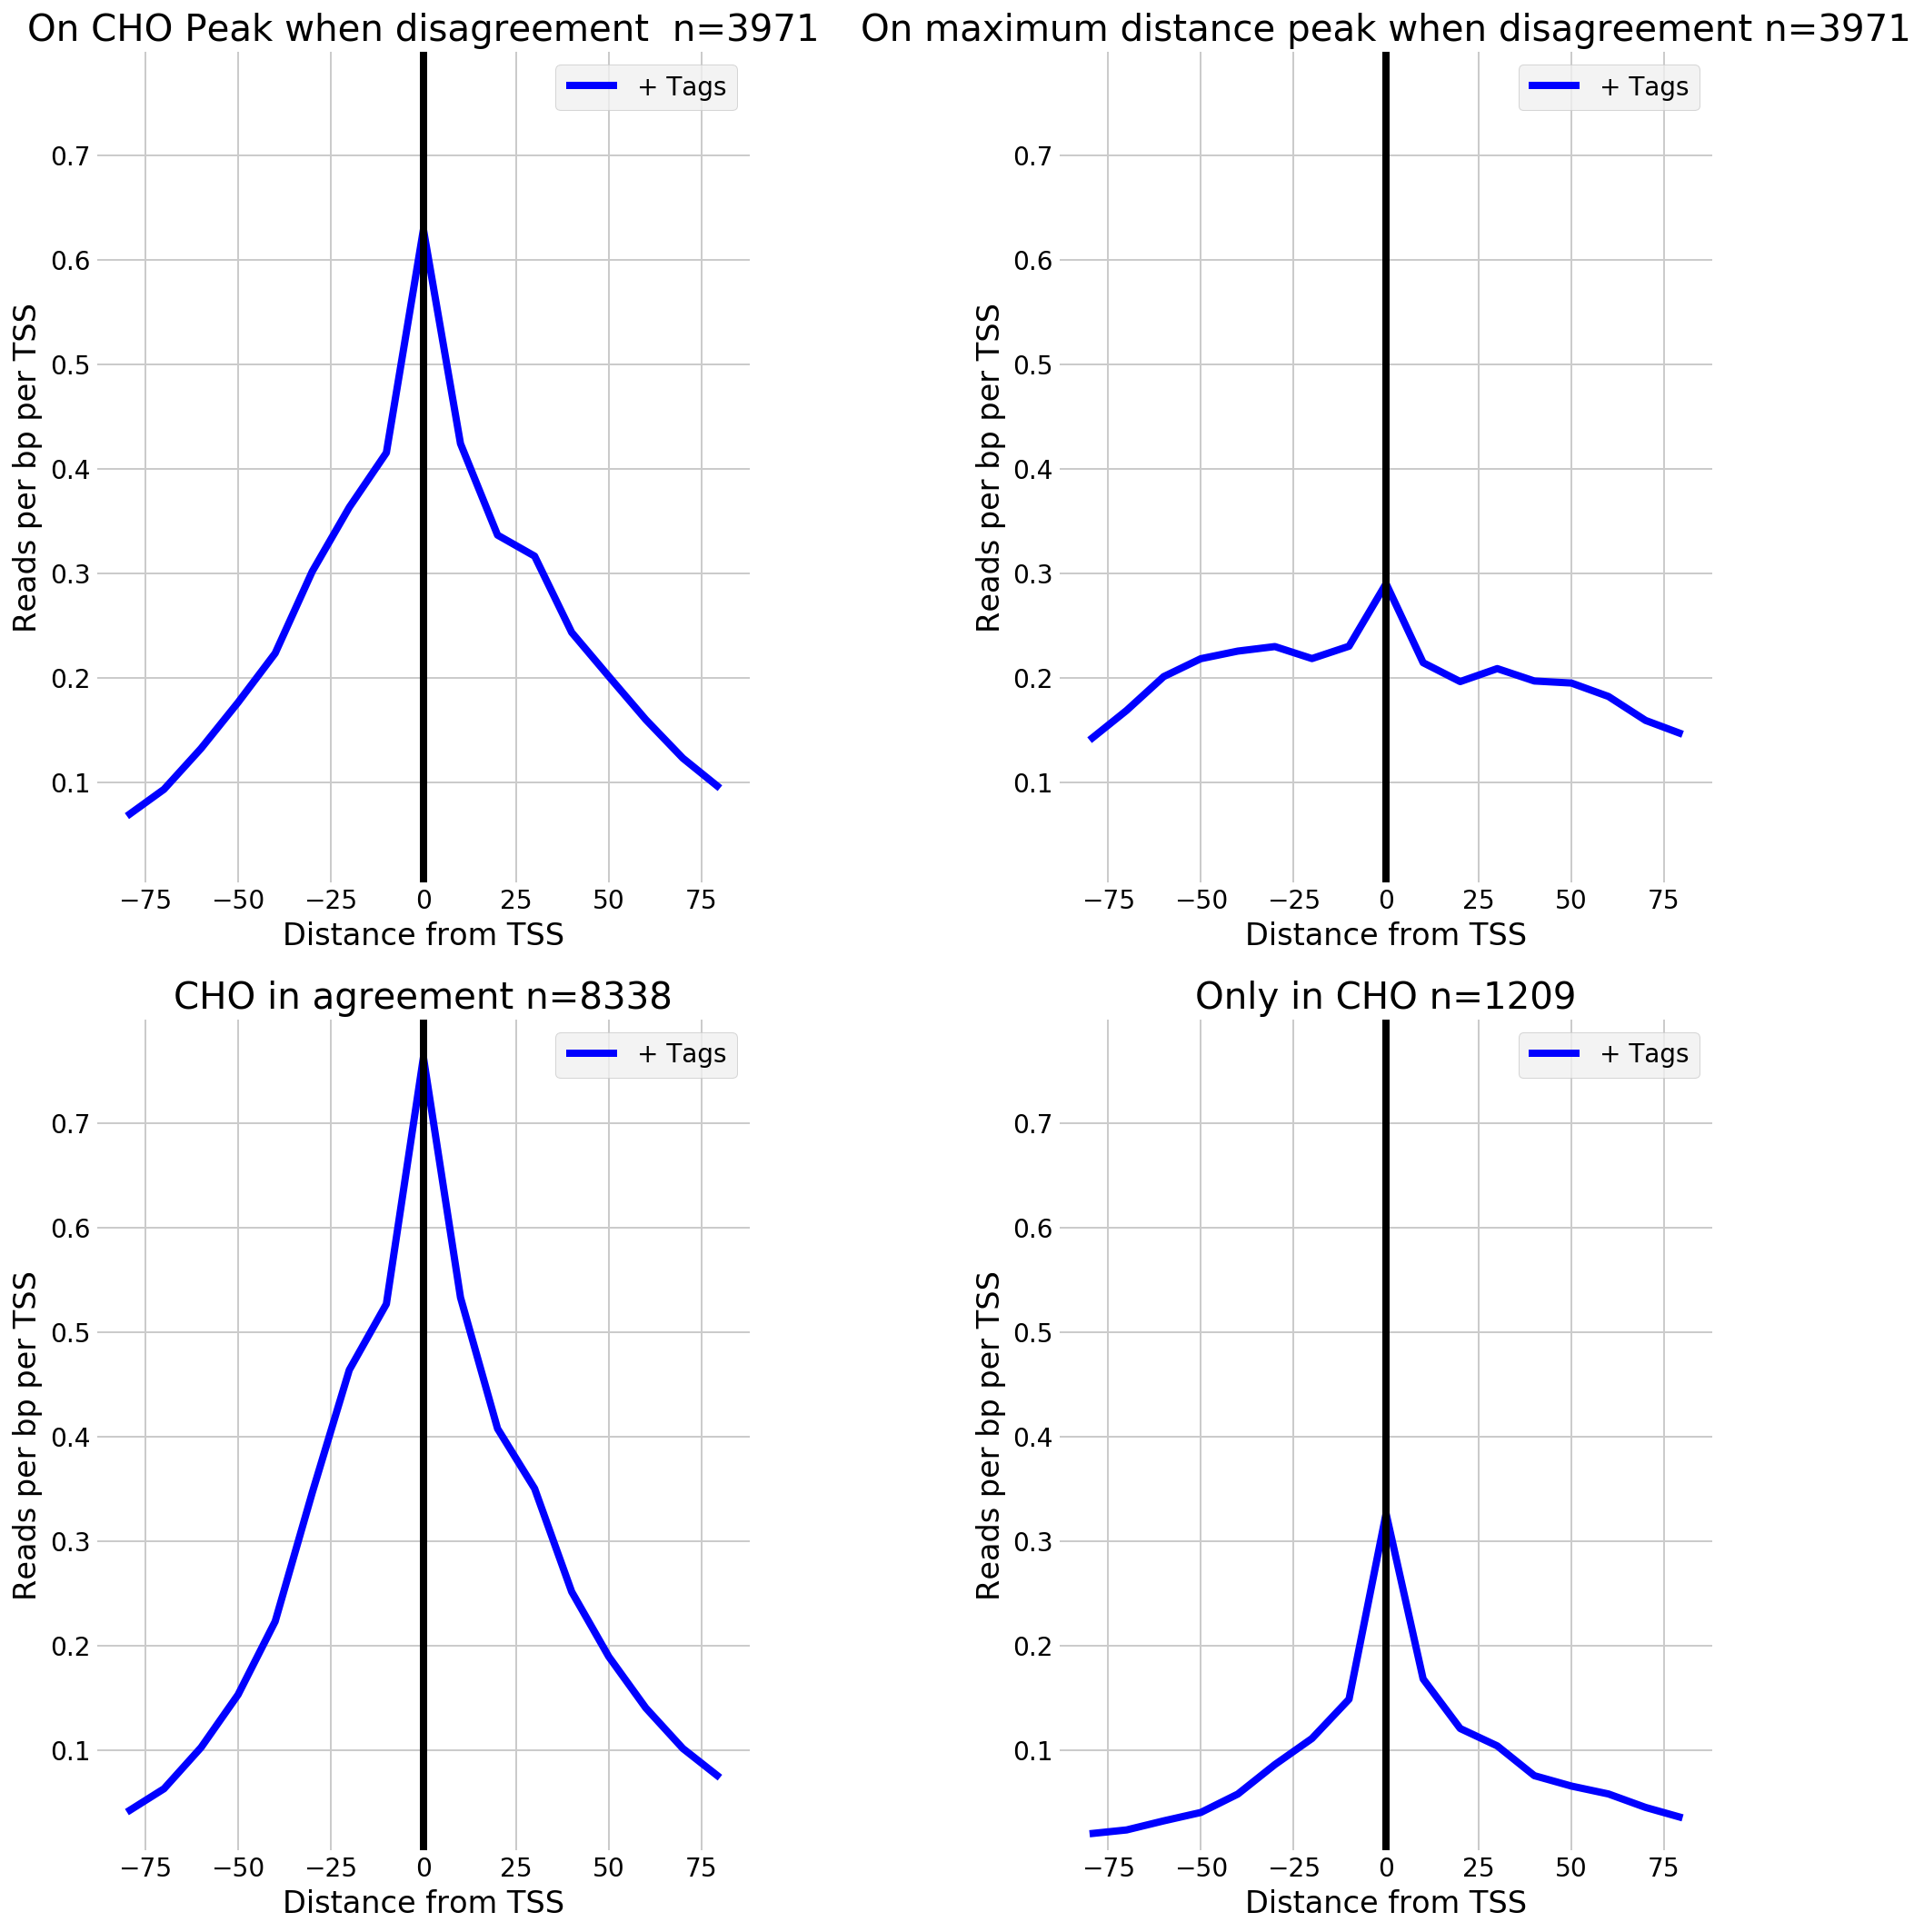

In [10]:
cho_dis3_maxDist_f = os.path.join(in_dir,"cho_disagree3_maxDistance_tol_25.tsv" )
cho_ag3_f = os.path.join(in_dir,"cho_agree3_tol_25.tsv" )
cho_dis3_f = os.path.join(in_dir,"cho_disagree3_tol_25.tsv" )
only_in_cho_f = os.path.join(in_dir, "cho_only_tol_25.tsv")


## Create RefSeq peak file for this
meta_f = "../Results/output/TSS1.exp.meta"

tissue = "CHO"
seq = "GROCap"
rep = "1"

tag_f = join(data_folder, tissue, seq, "f03_tags", "trim_" + tissue + "_" + seq + rep)


## 1.
hist_disagree3_maxDistance = join(save_dir,"hist_CHO_tags_disagree3_maxDistance_tol_25_reg150_res10")
hist(tag_f,hist_disagree3_maxDistance
     ,ref_fa,anno_gff,mode='peak',peak=cho_dis3_maxDist_f,region=150,res=10,pc=3,
    include_norm=False, include_heat=False)
n_disagree3_maxDistance = file_len(cho_dis3_maxDist_f) - 1

## 2. 
hist_cho_dis3 = join(save_dir,"hist_CHO_tags_cho_dis3_reg150_res10")
hist(tag_f,hist_cho_dis3,ref_fa,anno_gff,mode='peak',peak=cho_dis3_f,region=150,res=10,pc=3,
    include_norm=False, include_heat=False)
n_cho_dis3 = file_len(cho_dis3_f) - 1


## 3.
hist_cho_ag3 = join(save_dir,"hist_CHO_tags_cho_ag3_reg150_res10")
hist(tag_f,hist_cho_ag3,ref_fa,anno_gff,mode='peak',peak=cho_ag3_f,region=150,res=10,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_cho_ag3 = file_len(cho_ag3_f) - 1

hist_only_in_cho = join(save_dir,"hist_CHO_tags_only_in_cho_reg150_res10")
hist(tag_f,hist_only_in_cho,ref_fa,anno_gff,mode='peak',peak=only_in_cho_f,region=150,res=10,pc=3,
    include_norm=False, include_heat=False)
#hist_plot(hist_out_exp)
n_only_in_cho = file_len(only_in_cho_f) - 1

wrap_hist_plot([hist_cho_dis3, hist_disagree3_maxDistance, 
                hist_cho_ag3, hist_only_in_cho], hist_save=join(save_dir, "cho_tissues_tol25_reg150_res10"), 
                    names=["On CHO Peak when disagreement ","On maximum distance peak when disagreement", 
                          "CHO in agreement", "Only in CHO"], include_negative=False, n=[n_cho_dis3,n_disagree3_maxDistance,n_cho_ag3,n_only_in_cho], 
              xlims=None)


### With negative direction

Results/histograms/compare_tissues/Figures/hist_CHO_tags_disagree3_maxDistance_tol_25_reg150_res10 [-88.0, 88.0] [0.009234806143004424, 0.30362244461221605]
Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_dis3_reg150_res10 [-88.0, 88.0] [-0.019333068982870835, 0.6601077416916481]
Results/histograms/compare_tissues/Figures/hist_CHO_tags_cho_ag3_reg150_res10 [-88.0, 88.0] [-0.03205881400651958, 0.8009796678268034]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


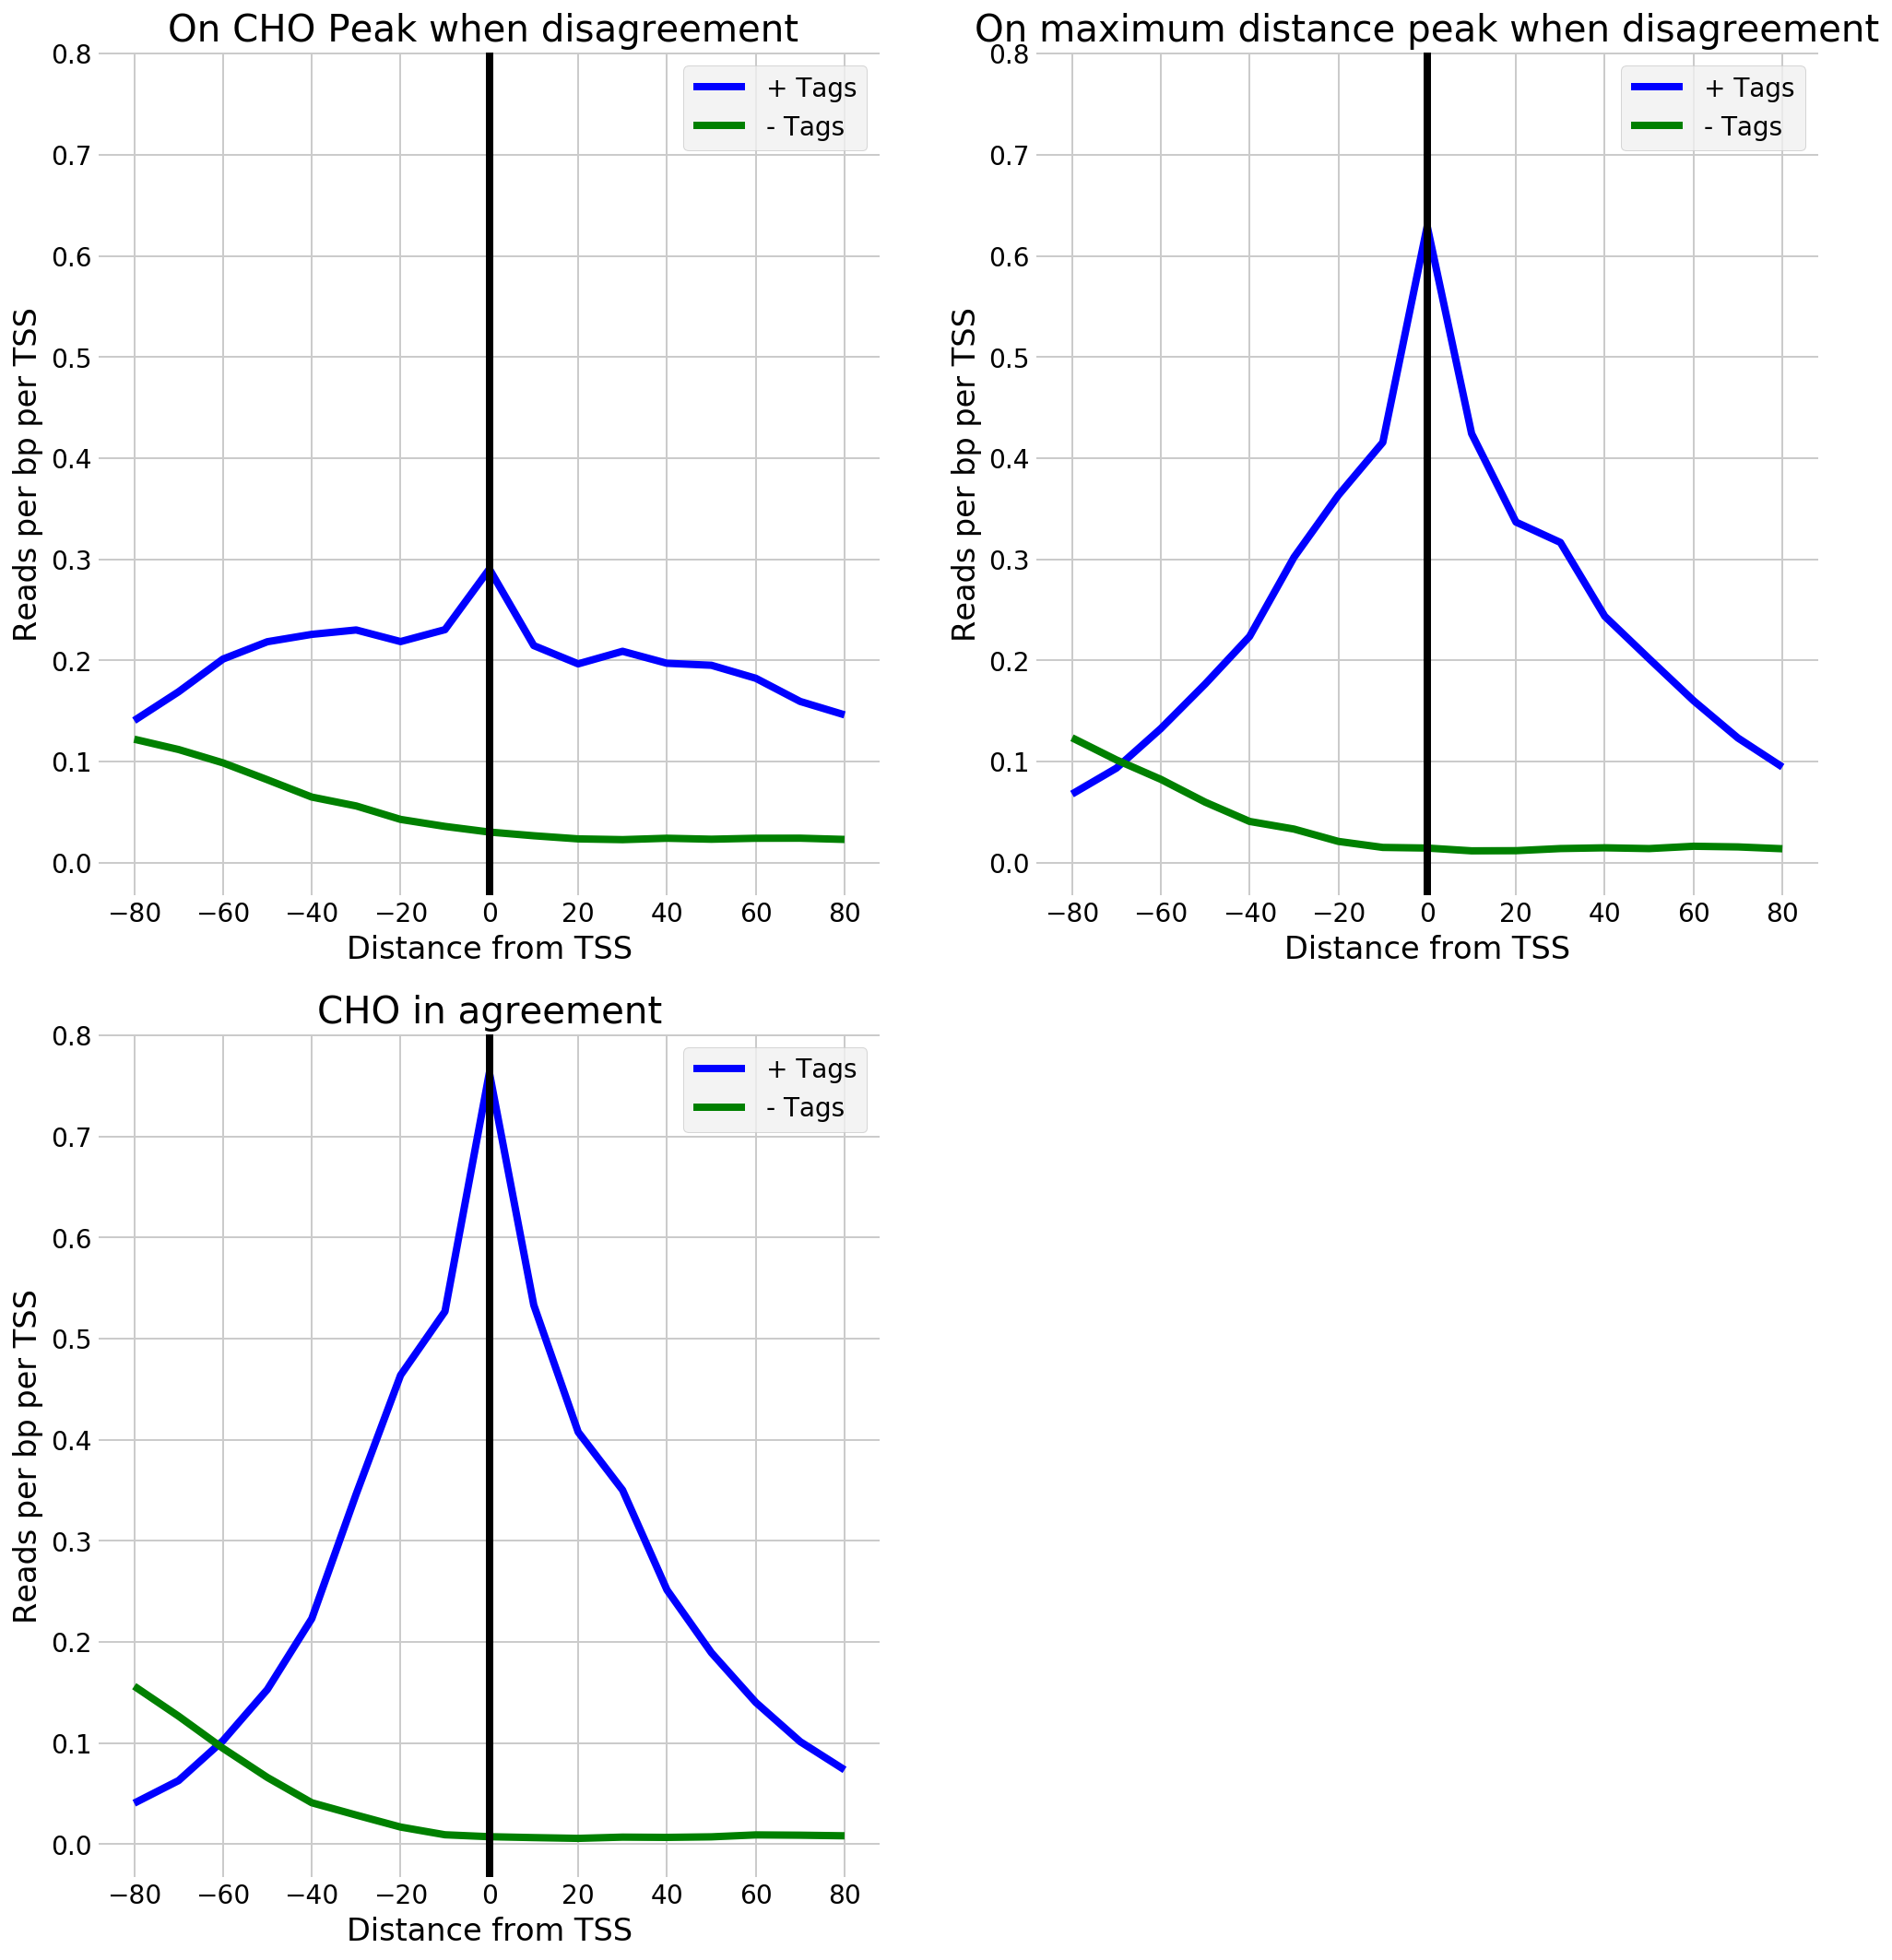

In [14]:
wrap_hist_plot([hist_disagree3_maxDistance ,
                hist_cho_dis3,hist_cho_ag3 ], hist_save=join(save_dir, "cho_tissues_divergent"), 
                    names=["On CHO Peak when disagreement ","On maximum distance peak when disagreement", 
                          "CHO in agreement"], include_negative=True, xlims=None)

In [47]:

def run_hist(peak_files, tag_f,f_save, out_hist, region, res, pc, label=None, names=None):
    hist_files = map(lambda x: join(out_hist,os.path.basename(x).replace(".tsv","")), peak_files)
    number_peaks = []
    for ind,h in enumerate(hist_files):
        print(h)
        p = peak_files[ind]
        hist(tag_f,h,ref_fa,anno_gff,mode='peak',peak=p,region=region,res=res,pc=pc, 
             include_norm=False, include_heat=False)
        number_peaks.append(file_len(h) - 1)
        
    if names==None:
        names = hist_files     
        
    wrap_hist_plot(hist_files, hist_save=join(out_hist, f_save), 
                    names=names, include_negative=False, n=number_peaks, 
              xlims=None, label=label)

    return


In [49]:
tissue = "CHO"
seq = "GROCap"
rep = "1"
tag_f = join(data_folder, tissue, seq, "f03_tags", "trim_" + tissue + "_" + seq + rep)


cho_dis3_maxDist_f = os.path.join(in_dir,"cho_disagree3_maxDistance_tol_0.tsv" )
cho_ag3_f = os.path.join(in_dir,"cho_agree3_tol_0.tsv" )
cho_dis3_f = os.path.join(in_dir,"cho_disagree3_tol_0.tsv" )
not_in_cho_f = os.path.join(in_dir, "not_in_cho.tsv")
only_in_cho_f = os.path.join(in_dir, "cho_only_tol_0.tsv")


peak_files = [cho_dis3_f,cho_dis3_maxDist_f,cho_ag3_f,not_in_cho_f, only_in_cho_f]
names = ["CHO dis3", "CHO dis 3 maximum distance", "CHO agree3", "Tissues not in CHO" ,"Only in CHO"]

out_hist = join(save_dir, "tol0_size150_res1_pc0")
if not os.path.exists(out_hist):
    os.mkdir(out_hist)
f_save = os.path.basename(tag_f)

run_hist(peak_files, tag_f, f_save, out_hist, region=150, res=1, pc=0, label=None, names=names)


Results/histograms/compare_tissues/Figures/tol0_size150_res1_pc0/cho_disagree3_tol_0
annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 0 > Results/histograms/compare_tissues/Figures/tol0_size150_res1_pc0/cho_disagree3_tol_0
Results/histograms/compare_tissues/Figures/tol0_size150_res1_pc0/cho_disagree3_maxDistance_tol_0
annotatePeaks.pl Results/histograms/compare_tissues/cho_disagree3_maxDistance_tol_0.tsv /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -gff /data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 -fragLength 1 -size 150 -hist 1 -d /data/isshamie/TSS/NCBI_PICR_103_Processed/CHO/GROCap/f03_tags/trim_CHO_GROCap1 -pc 0 > Results/histograms/compare_

TypeError: object of type 'map' has no len()